# LU-BSS Integration Analysis

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import requests
import json
import geopandas as gpd
from shapely.geometry import Point, Polygon
import re
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import make_interp_spline
from scipy.stats import gaussian_kde
import tensorly as tl
from tensorly.decomposition import tucker, non_negative_tucker
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Wrangling

In [2]:
# bike trip data for a full year
dataframes = [
    pd.read_csv('https://github.com/tianzhhai/dissertation/raw/main/chunk_0.zip', compression='zip'),
    pd.read_csv('https://github.com/tianzhhai/dissertation/raw/main/chunk_1.zip', compression='zip'),
    pd.read_csv('https://github.com/tianzhhai/dissertation/raw/main/chunk_2.zip', compression='zip'),
    pd.read_csv('https://github.com/tianzhhai/dissertation/raw/main/chunk_3.zip', compression='zip'),
    pd.read_csv('https://github.com/tianzhhai/dissertation/raw/main/chunk_4.zip', compression='zip'),
    pd.read_csv('https://github.com/tianzhhai/dissertation/raw/main/chunk_5.zip', compression='zip'),
    pd.read_csv('https://github.com/tianzhhai/dissertation/raw/main/chunk_6.zip', compression='zip'),
    pd.read_csv('https://github.com/tianzhhai/dissertation/raw/main/chunk_7.zip', compression='zip'),
    pd.read_csv('https://github.com/tianzhhai/dissertation/raw/main/chunk_8.zip', compression='zip')
]

df = pd.concat(dataframes, ignore_index=True)

# London 
london = gpd.read_file("https://github.com/tianzhhai/dissertation/raw/main/London_Borough_Excluding_MHW.shp")

# study area
scope = gpd.read_file("https://github.com/tianzhhai/dissertation/raw/main/scope.geojson")

# metro station in the study area
metro = gpd.read_file("https://github.com/tianzhhai/dissertation/raw/main/metroscope.geojson")

# bike station in the study area
bikestation = gpd.read_file('https://github.com/tianzhhai/dissertation/raw/main/bikepoints_con.geojson')

# lane_density
lane = gpd.read_file("https://github.com/tianzhhai/dissertation/raw/main/lane_density.geojson")

## Bike trip data

In [4]:
df.shape

(8429864, 6)

In [5]:
# Screening for valid trips within one year
df_clean = df[(df['Duration'] > 60) & (df['Duration'] < 7200)]
df_clean = df_clean[df_clean['End_station'] != df_clean['Start_station']]
df_clean.shape

(8054035, 6)

In [6]:
# Extract time characteristics
df_clean['Start_date'] = pd.to_datetime(df_clean['Start_date'], format='%Y/%m/%d %H:%M')
df_clean['End_date'] = pd.to_datetime(df_clean['End_date'], format='%Y/%m/%d %H:%M')

df_clean['Date'] = df_clean['Start_date'].dt.date
df_clean['Month'] = df_clean['Start_date'].dt.month
df_clean['Day'] = df_clean['Start_date'].dt.day
df_clean['Hour'] = df_clean['Start_date'].dt.hour
df_clean['minute_mark'] = (df_clean['Start_date'].dt.minute)//15

df_clean['Day_of_week'] = df_clean['Start_date'].dt.dayofweek
df_clean['Weekday'] = df_clean['Start_date'].dt.day_name()
df_clean['is_weekday'] = df_clean['Day_of_week'] < 5
df_clean['day_type'] = df_clean['is_weekday'].apply(lambda x: 'Weekday' if x else 'Weekend')

df_clean['is_AM_peak'] = (df_clean['day_type'] == 'Weekday') & ((df_clean['Hour'].isin([7, 8])) | ((df_clean['Hour'] == 6)&(df_clean['minute_mark']>1)) | ((df_clean['Hour'] == 9)&(df_clean['minute_mark']<2)))
df_clean['is_PM_peak'] = (df_clean['day_type'] == 'Weekday') & (df_clean['Hour'].isin([16, 17, 18]))
df_clean['period'] = df_clean['is_AM_peak'].apply(lambda x: 'AMpeak' if x else 'offpeak')
df_clean['period'] = df_clean.apply(
    lambda row: 'PMpeak' if row['is_PM_peak'] else row['period'], axis=1
)

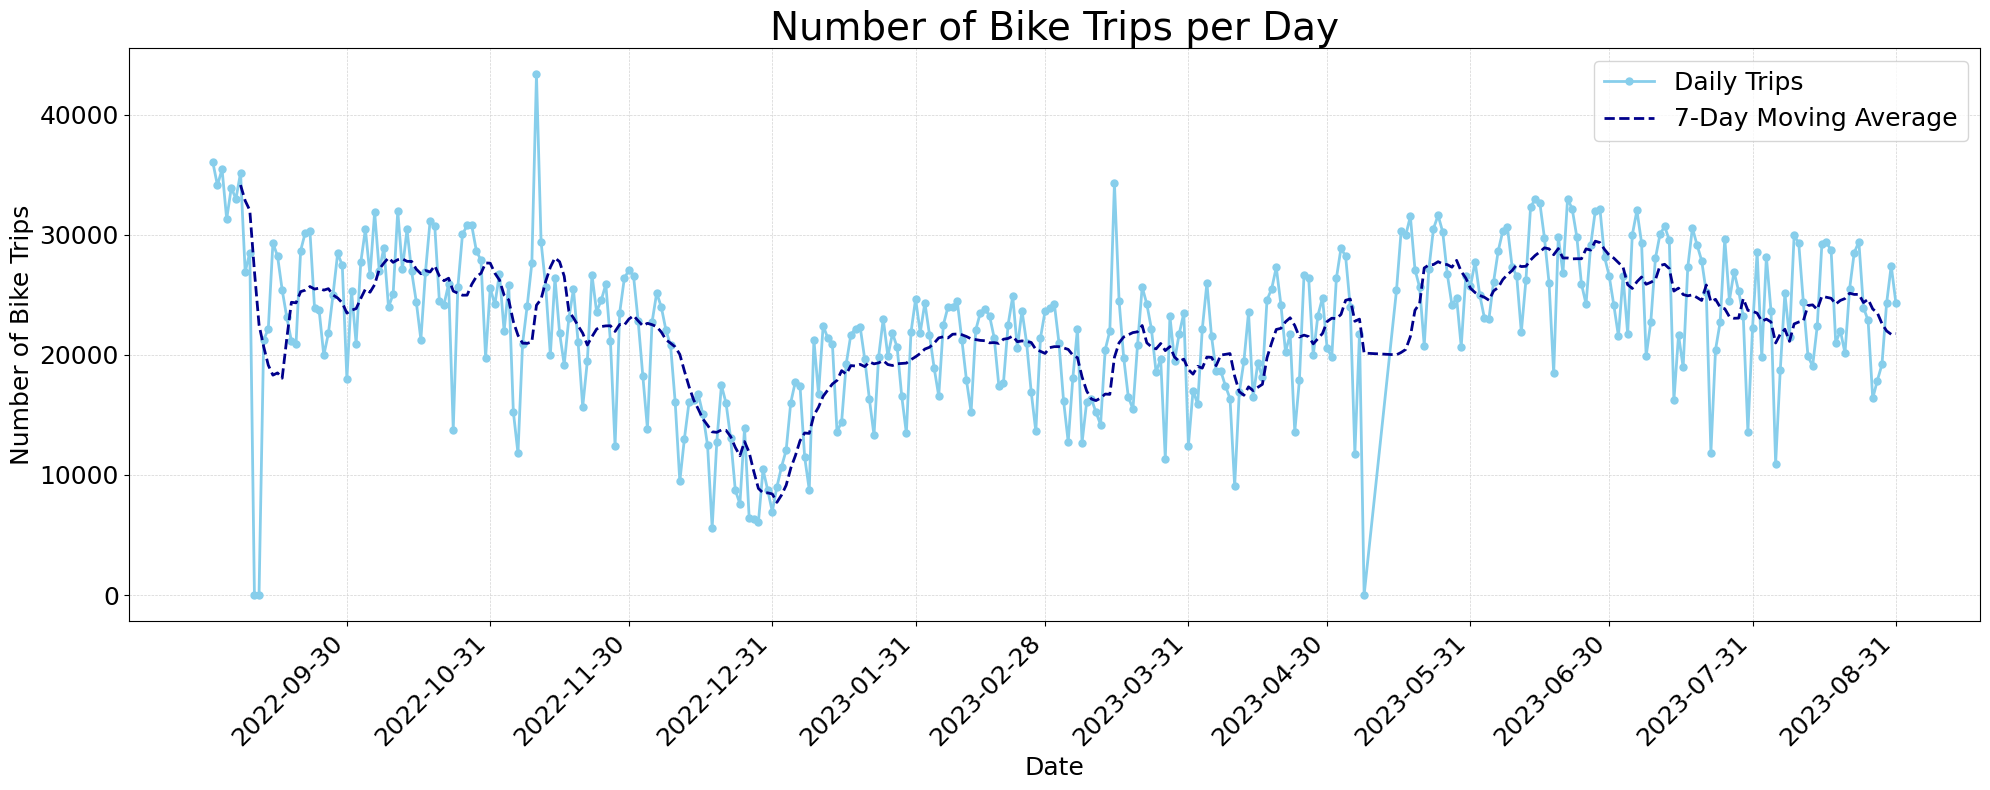

In [7]:
# Daily bike trips during the year
daily_counts = df_clean['Date'].value_counts().sort_index()

plt.figure(figsize=(20, 8))

plt.plot(daily_counts.index, daily_counts.values, marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=5, label='Daily Trips')

rolling_mean = daily_counts.rolling(window=7).mean()
plt.plot(daily_counts.index, rolling_mean, color='darkblue', linestyle='--', linewidth=2, label='7-Day Moving Average')

plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('white')

plt.title('Number of Bike Trips per Day', fontsize=28)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of Bike Trips', fontsize=18)

plt.xticks(pd.date_range(start=daily_counts.index.min(), end=daily_counts.index.max(), freq='M'), rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18)
plt.tight_layout()

plt.show()

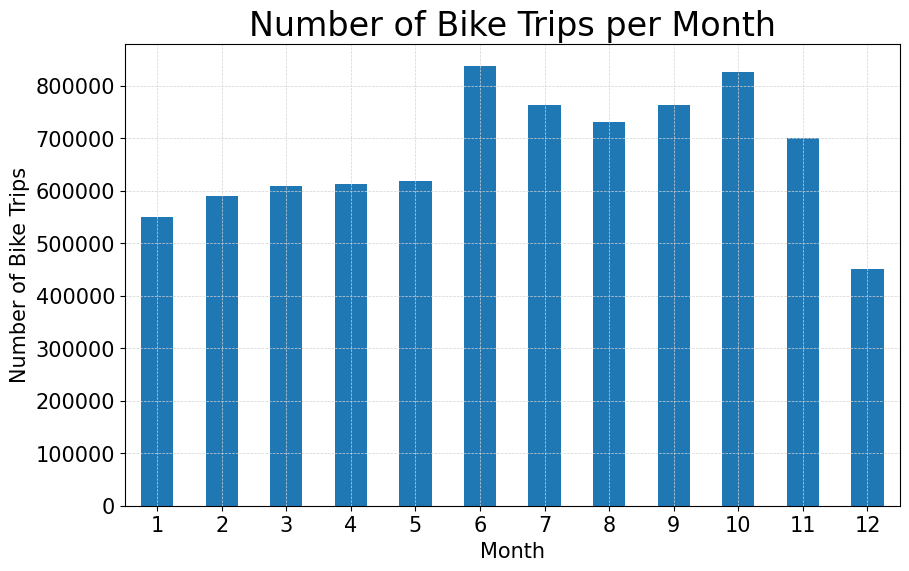

In [8]:
# Monthly trips during the year
month_counts = df_clean['Month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))

month_counts.plot(kind='bar')

plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('white')

plt.title('Number of Bike Trips per Month', fontsize=24)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Number of Bike Trips', fontsize=15)

plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)

plt.show()

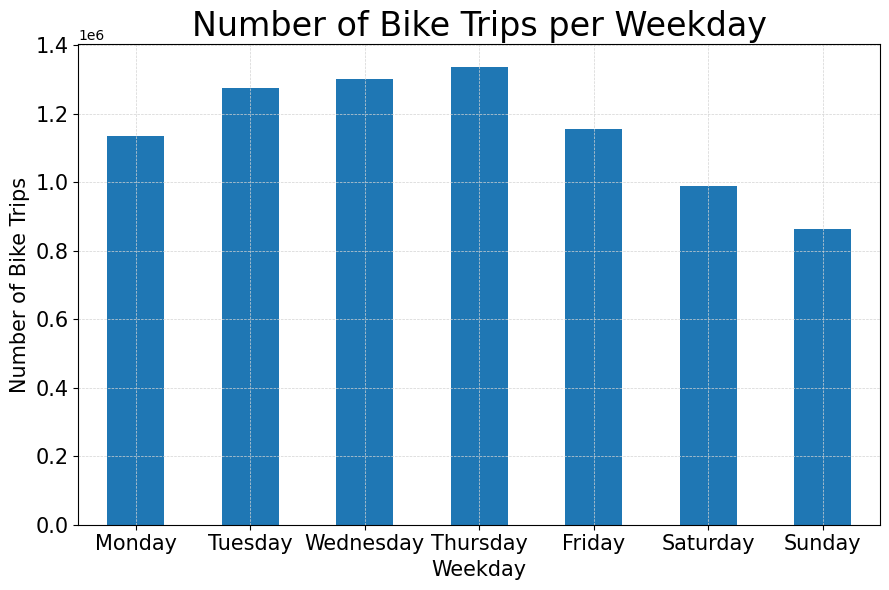

In [9]:
# Trips by day of the week during the year
weekday_counts = df_clean['Weekday'].value_counts()[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

plt.figure(figsize=(9, 6))

weekday_counts.plot(kind='bar')

plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('white')

plt.title('Number of Bike Trips per Weekday', fontsize=24)
plt.xlabel('Weekday', fontsize=15)
plt.ylabel('Number of Bike Trips', fontsize=15)

plt.xticks(rotation=0,fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

### Bike trips in October 

In [10]:
df_October = df_clean[df_clean['Month'] == 10]
df_October.shape

(826085, 18)

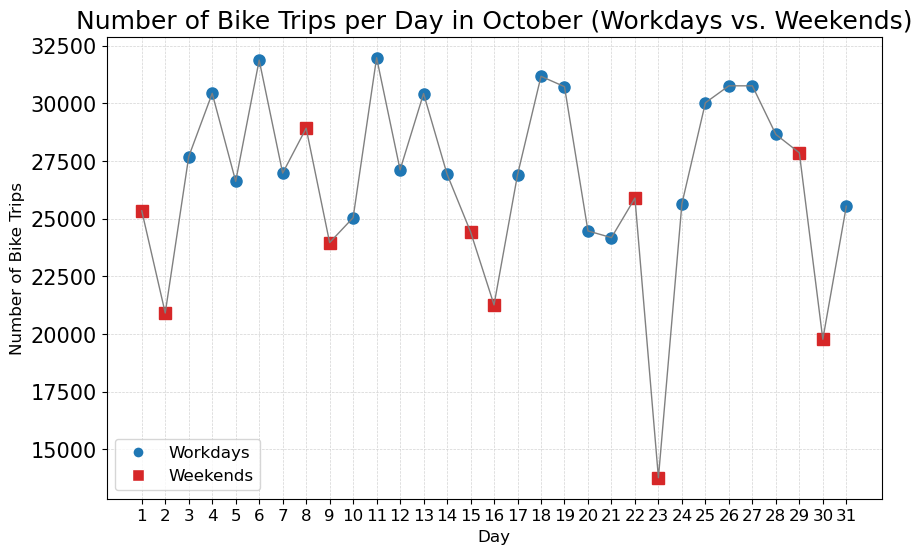

In [11]:
# Daily trips in October
daily_counts = df_October['Day'].value_counts().sort_index()

plt.figure(figsize=(10, 6))

for day in daily_counts.index:
    if df_October[df_October['Day'] == day]['Day_of_week'].iloc[0] < 5:
        plt.plot(day, daily_counts[day], marker='o', color='tab:blue', markersize=8)
    else:
        plt.plot(day, daily_counts[day], marker='s', color='tab:red', markersize=8)

plt.plot(daily_counts.index, daily_counts.values, color='gray', linestyle='-', linewidth=1)

# plt.ylim(0, daily_counts.max() + daily_counts.max() * 0.1)

plt.title('Number of Bike Trips per Day in October (Workdays vs. Weekends)', fontsize=18)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Number of Bike Trips', fontsize=12)

plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('white')

plt.xticks(ticks=range(1, 32), fontsize=12)
plt.yticks(fontsize=15)

blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=8, label='Workdays')
red_patch = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='tab:red', markersize=8, label='Weekends')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)

plt.show()

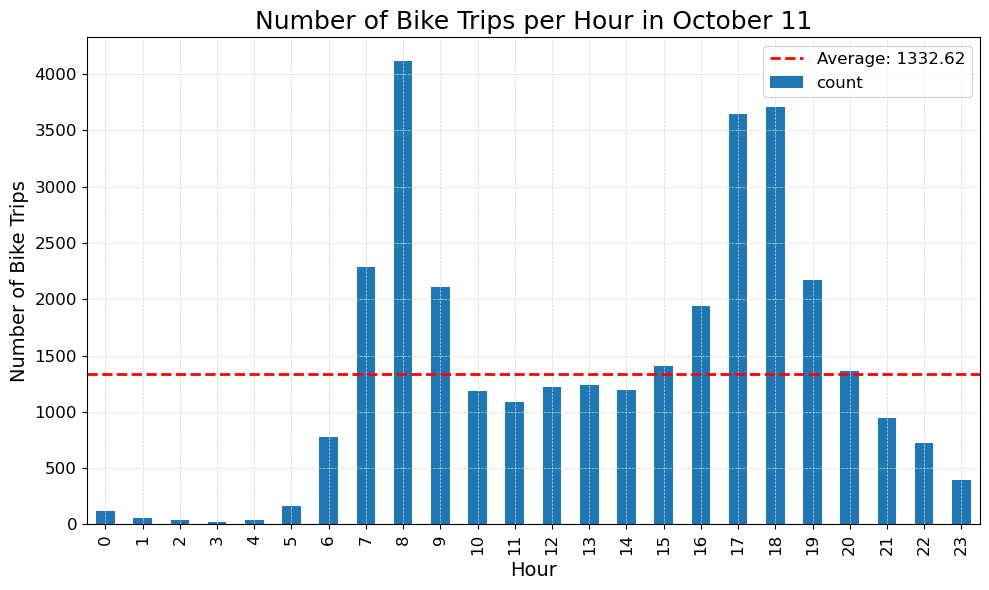

In [12]:
# Hourly trips in October 11
df_October11 = df_October[df_October['Day'] == 11]
counts = df_October11['Hour'].value_counts().sort_index()
mean_trips = counts.mean()

plt.figure(figsize=(10, 6))

counts.plot(kind='bar')

plt.axhline(mean_trips, color='red', linestyle='--', linewidth=2, label=f'Average: {mean_trips:.2f}')


plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('white')

plt.title('Number of Bike Trips per Hour in October 11', fontsize=18)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Number of Bike Trips', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

In [13]:
counts = df_October['period'].value_counts().sort_index()
counts

period
AMpeak     135120
PMpeak     167457
offpeak    523508
Name: count, dtype: int64

#### Distribution of duration of all trips in October

In [14]:
df_October['Duration'].describe(percentiles=[.05, .25, .5, .75, .95])

count    826085.000000
mean        977.098393
std         786.223379
min          61.000000
5%          219.000000
25%         473.000000
50%         782.000000
75%        1234.000000
95%        2373.000000
max        7199.000000
Name: Duration, dtype: float64

<Axes: xlabel='Duration', ylabel='Count'>

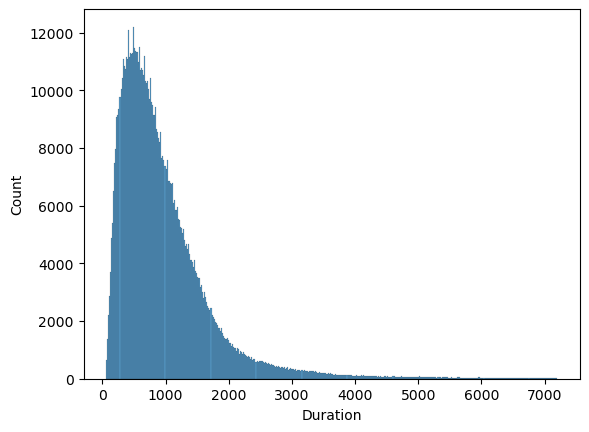

In [15]:
sns.histplot(df_October['Duration'])

#### Categorise the October trips by each bike station and calculate the average daily usage for each station

In [16]:
start_counts = df_October.groupby(['Date', 'Start_station']).size().reset_index(name='start_count')
start_counts.rename(columns={'Start_station': 'Station'}, inplace=True)

end_counts = df_October.groupby(['Date', 'End_station']).size().reset_index(name='end_count')
end_counts.rename(columns={'End_station': 'Station'}, inplace=True)

daily_usage = pd.merge(start_counts, end_counts, left_on=['Date', 'Station'], right_on=['Date', 'Station'], how='outer', suffixes=('_start', '_end'))

daily_usage['start_count'] = daily_usage['start_count'].fillna(0)
daily_usage['end_count'] = daily_usage['end_count'].fillna(0)

daily_usage['total_count'] = daily_usage['start_count'] + daily_usage['end_count']

In [17]:
station_avg_daily_usage = daily_usage.groupby('Station').agg(
    avg_start_count=('start_count', 'mean'),
    avg_end_count=('end_count', 'mean'),
    avg_total_count=('total_count', 'mean')
).reset_index()

station_avg_daily_usage = station_avg_daily_usage.round({
    'avg_start_count': 0,
    'avg_end_count': 0,
    'avg_total_count': 0
})

station_avg_daily_usage = station_avg_daily_usage.sort_values(by='avg_total_count', ascending=False).reset_index(drop=True)

station_avg_daily_usage.head(10)

Station  avg_start_count  avg_end_count  \
0            Hop Exchange, The Borough            113.0          153.0   
1         Waterloo Station 3, Waterloo            127.0          136.0   
2       Belgrove Street , King's Cross            121.0          125.0   
3    Wormwood Street, Liverpool Street            117.0          117.0   
4  Brushfield Street, Liverpool Street            105.0          123.0   
5          Hyde Park Corner, Hyde Park            111.0          115.0   
6         Waterloo Station 1, Waterloo            109.0          115.0   
7       Exhibition Road, Knightsbridge            103.0          116.0   
8      Duke Street Hill, London Bridge            102.0          114.0   
9      St. James's Square, St. James's             89.0          118.0   

   avg_total_count  
0            266.0  
1            263.0  
2            245.0  
3            233.0  
4            229.0  
5            226.0  
6            224.0  
7            218.0  
8            215.0  
9            207.0

In [18]:
station_usage = daily_usage.groupby('Station')['total_count'].sum().reset_index(name='total_usage')
station_days = daily_usage.groupby('Station')['Date'].nunique().reset_index(name='active_days')

average_usage = pd.merge(station_usage, station_days, on='Station')

average_usage['daily_average'] = average_usage['total_usage'] / average_usage['active_days']

average_usage.sort_values(by='daily_average', ascending=False).reset_index(drop=True)

Station  total_usage  active_days  \
0                        Hop Exchange, The Borough       8247.0           31   
1                     Waterloo Station 3, Waterloo       8149.0           31   
2                   Belgrove Street , King's Cross       7608.0           31   
3                Wormwood Street, Liverpool Street       7237.0           31   
4              Brushfield Street, Liverpool Street       7091.0           31   
..                                             ...          ...          ...   
792                 Stebondale Street, Cubitt Town        296.0           31   
793                      Mudchute DLR, Cubitt Town        292.0           31   
794  Here East South, Queen Elizabeth Olympic Park        270.0           29   
795                  South Quay East, Canary Wharf        263.0           31   
796                          Millharbour, Millwall        247.0           30   

     daily_average  
0       266.032258  
1       262.870968  
2       245.419355  
3       233.451613  
4       228.741935  
..             ...  
792       9.548387  
793       9.419355  
794       9.310345  
795       8.483871  
796       8.233333  

[797 rows x 4 columns]

In [19]:
station_avg_daily_usage['avg_total_count'].describe(percentiles=[.05, .25, .5, .75, .95])

count    797.000000
mean      67.114178
std       38.260720
min        8.000000
5%        20.000000
25%       41.000000
50%       60.000000
75%       82.000000
95%      140.400000
max      266.000000
Name: avg_total_count, dtype: float64

<Axes: xlabel='avg_total_count', ylabel='Count'>

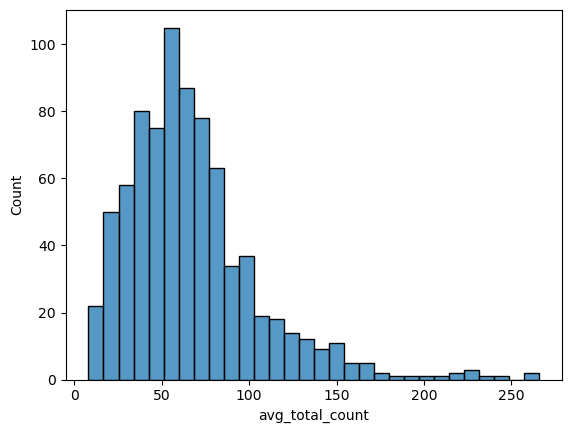

In [20]:
sns.histplot(station_avg_daily_usage['avg_total_count'])

## Bike station

In [21]:
bikestation.shape

(797, 16)

In [22]:
bikestation['NbDocks'] = bikestation['NbDocks'].astype(int)
bikestation['TerminalName'] = bikestation['TerminalName'].astype(int)

#### Harmonisation of bike station names for trip data and bike station data

In [23]:
df_clean.loc[df_clean['Start_station'] == "Belgrove Street , King's Cross", 'Start_station'] = 'Argyle Street, Kings Cross'
df_clean.loc[df_clean['End_station'] == "Belgrove Street , King's Cross", 'End_station'] = 'Argyle Street, Kings Cross'

df_clean.loc[df_clean['Start_station'] == "Regent's Row , Haggerston ", 'Start_station'] = "Regent's Row , Haggerston"
df_clean.loc[df_clean['End_station'] == "Regent's Row , Haggerston ", 'End_station'] = "Regent's Row , Haggerston"

df_clean.loc[df_clean['Start_station'] == "Kennington Road  , Vauxhall", 'Start_station'] = "Kennington Road, Vauxhall"
df_clean.loc[df_clean['End_station'] == "Kennington Road  , Vauxhall", 'End_station'] = "Kennington Road, Vauxhall"

df_clean.loc[df_clean['Start_station'] == "Strand, Strand_OLD", 'Start_station'] = "Strand, Strand"
df_clean.loc[df_clean['End_station'] == "Strand, Strand_OLD", 'End_station'] = "Strand, Strand"

df_clean.loc[df_clean['Start_station'] == "Hardwick Street, Clerkenwell_old2", 'Start_station'] = "Hardwick Street, Clerkenwell"
df_clean.loc[df_clean['End_station'] == "Hardwick Street, Clerkenwell_old2", 'End_station'] = "Hardwick Street, Clerkenwell"

df_clean.loc[df_clean['Start_station'] == "Disraeli Road, Putney2", 'Start_station'] = "Disraeli Road, Putney"
df_clean.loc[df_clean['End_station'] == "Disraeli Road, Putney2", 'End_station'] = "Disraeli Road, Putney"

df_clean.loc[df_clean['Start_station'] == "Coomer Place, West Kensington_OLD", 'Start_station'] = "Coomer Place, West Kensington"
df_clean.loc[df_clean['End_station'] == "Coomer Place, West Kensington_OLD", 'End_station'] = "Coomer Place, West Kensington"

#### Screening of trips whose starting and ending stations are still present in the current site inventory for subsequent spatial analyses

In [24]:
df_spatial = df_clean[(df_clean['Start_station'].isin(bikestation['name'])) & (df_clean['End_station'].isin(bikestation['name']))]
df_spatial.shape

(7870606, 18)

## Metro station

In [25]:
metro.shape

(112, 59)

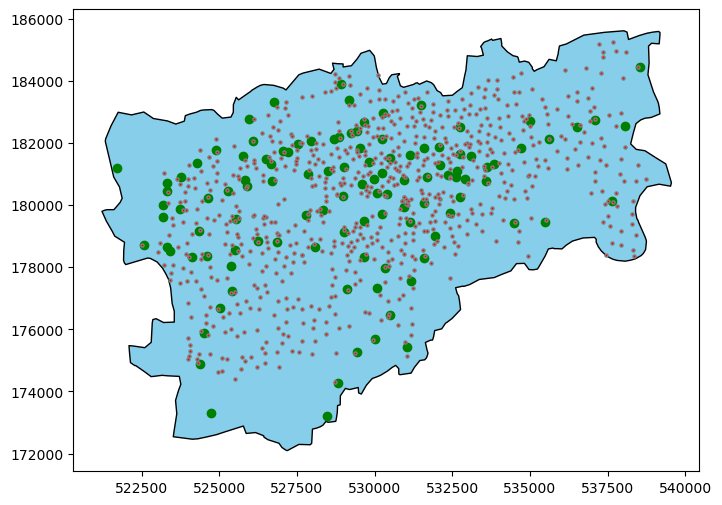

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

scope.plot(ax=ax, color='skyblue', edgecolor='black', facecolor='lightblue')
metro.plot(ax=ax, color='green', edgecolor='green', alpha=1, label='Layer 2')
bikestation.plot(ax=ax, color='red', edgecolor='gray', alpha=1, markersize=5, label='Layer 2')

plt.show()

In [27]:
# Converting MULTIPOINT to POINT

point_list = []
original_data = []

for idx, row in metro.iterrows():
    geom = row.geometry
    if geom.geom_type == 'MultiPoint':
        for point in geom.geoms:
            point_list.append(point)
            original_data.append(row.drop('geometry'))
    elif geom.geom_type == 'Point':
        point_list.append(geom)
        original_data.append(row.drop('geometry'))

points_df = pd.DataFrame(original_data)
points_df['geometry'] = point_list

points_metro = gpd.GeoDataFrame(points_df, geometry='geometry', crs=metro.crs)

## Metro flow

In [28]:
fll = pd.DataFrame()

In [29]:
fl = pd.read_csv("https://github.com/tianzhhai/dissertation/raw/main/NBT22MON_Outputs.csv")
fl.iloc[:, 10:106] = fl.iloc[:, 10:106].applymap(lambda x: int(str(x).replace(',', '')))
fl['Total'] = fl['Total'].str.replace(',', '').astype(int)

fll['Station'] = fl['Station']
fll['Monday'] = fl['Total']

for i in range(24):
    start_col = 10 + i * 4
    end_col = start_col + 4
    fll[f'M{i+5}'] = fl.iloc[:, start_col:end_col].sum(axis=1)
    
fll.rename(columns={
    'M24': 'M0',
    'M25': 'M1',
    'M26': 'M2',
    'M27': 'M3',
    'M28': 'M4'
}, inplace=True)
    
fll['M_AM_Peak'] = np.round(fl.iloc[:, 16:28].astype(float).sum(axis=1) / 3).astype(int)
fll['M_PM_Peak'] = np.round(fl.iloc[:, 54:66].astype(float).sum(axis=1) / 3).astype(int)

In [30]:
fl = pd.read_csv("https://github.com/tianzhhai/dissertation/raw/main/NBT22TWT_Outputs.csv")
fl.iloc[:, 10:106] = fl.iloc[:, 10:106].applymap(lambda x: int(str(x).replace(',', '')))
fl['Total'] = fl['Total'].str.replace(',', '').astype(int)

fll['TWT'] = fl['Total']

for i in range(24):
    start_col = 10 + i * 4
    end_col = start_col + 4
    fll[f'T{i+5}'] = fl.iloc[:, start_col:end_col].sum(axis=1)
    
fll.rename(columns={
    'T24': 'T0',
    'T25': 'T1',
    'T26': 'T2',
    'T27': 'T3',
    'T28': 'T4'
}, inplace=True)

fll['T_AM_Peak'] = np.round(fl.iloc[:, 16:28].astype(float).sum(axis=1) / 3).astype(int)
fll['T_PM_Peak'] = np.round(fl.iloc[:, 54:66].astype(float).sum(axis=1) / 3).astype(int)

In [31]:
fl = pd.read_csv("https://github.com/tianzhhai/dissertation/raw/main/NBT22FRI_Outputs.csv")
fl.iloc[:, 10:106] = fl.iloc[:, 10:106].applymap(lambda x: int(str(x).replace(',', '')))
fl['Total'] = fl['Total'].str.replace(',', '').astype(int)

fll['Friday'] = fl['Total']

for i in range(24):
    start_col = 10 + i * 4
    end_col = start_col + 4
    fll[f'F{i+5}'] = fl.iloc[:, start_col:end_col].sum(axis=1)
    
fll.rename(columns={
    'F24': 'F0',
    'F25': 'F1',
    'F26': 'F2',
    'F27': 'F3',
    'F28': 'F4'
}, inplace=True)

fll['F_AM_Peak'] = np.round(fl.iloc[:, 16:28].astype(float).sum(axis=1) / 3).astype(int)
fll['F_PM_Peak'] = np.round(fl.iloc[:, 54:66].astype(float).sum(axis=1) / 3).astype(int)

In [32]:
fl = pd.read_csv("https://github.com/tianzhhai/dissertation/raw/main/NBT22SAT_Outputs.csv")
fl.iloc[:, 10:106] = fl.iloc[:, 10:106].applymap(lambda x: int(str(x).replace(',', '')))
fl['Total'] = fl['Total'].str.replace(',', '').astype(int)

fll['Saturday'] = fl['Total']

for i in range(24):
    start_col = 10 + i * 4
    end_col = start_col + 4
    fll[f'S{i+5}'] = fl.iloc[:, start_col:end_col].sum(axis=1)
    
fll.rename(columns={
    'S24': 'S0',
    'S25': 'S1',
    'S26': 'S2',
    'S27': 'S3',
    'S28': 'S4'
}, inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_28952\763344943.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fll[f'S{i+5}'] = fl.iloc[:, start_col:end_col].sum(axis=1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_28952\763344943.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fll[f'S{i+5}'] = fl.iloc[:, start_col:end_col].sum(axis=1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_28952\763344943.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [33]:
fl = pd.read_csv("https://github.com/tianzhhai/dissertation/raw/main/NBT22SUN_Outputs.csv")
fl.iloc[:, 10:106] = fl.iloc[:, 10:106].applymap(lambda x: int(str(x).replace(',', '')))
fl['Total'] = fl['Total'].str.replace(',', '').astype(int)

fll['Sunday'] = fl['Total']

for i in range(24):
    start_col = 10 + i * 4
    end_col = start_col + 4
    fll[f'U{i+5}'] = fl.iloc[:, start_col:end_col].sum(axis=1)
    
fll.rename(columns={
    'U24': 'U0',
    'U25': 'U1',
    'U26': 'U2',
    'U27': 'U3',
    'U28': 'U4'
}, inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_28952\1840906192.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fll['Sunday'] = fl['Total']
C:\Users\DELL\AppData\Local\Temp\ipykernel_28952\1840906192.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fll[f'U{i+5}'] = fl.iloc[:, start_col:end_col].sum(axis=1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_28952\1840906192.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

In [34]:
fll

Station  Monday  M5   M6    M7    M8    M9   M10  M11  \
0                Abbey Road    2038  22  109   159   163    82    57   56   
1             Acton Central    2895   0   50   295   325   150    91   74   
2           Acton Main Line    2570  13   63   176   163    71    47   47   
3                Acton Town    7403  27  251   663   708   334   192  177   
4         Addington Village       0   0    0     0     0     0     0    0   
..                      ...     ...  ..  ...   ...   ...   ...   ...  ...   
466         Canary Wharf EL   20898  65  739  1894  3164  2482  1070  745   
467              Abbey Wood   22098   6  177   743   887   531   360  385   
468         Custom House EL   12097  36  286   657   760   624   496  464   
469             Woolwich EL   14593   9  146   413   540   405   301  317   
470  Heathrow Terminal 5 EL    3546  87  312   282   222   203   171  194   

     M12  ...   U19  U20  U21  U22  U23  U0 U1 U2 U3 U4  
0     63  ...    78   63   58   57   46   3  0  0  0  0  
1     81  ...    87   63   55   51   29   0  0  0  0  0  
2     64  ...   116  103   94   78    9   0  0  0  0  0  
3    204  ...   398  269  252  234  180  63  2  0  0  0  
4      0  ...     0    0    0    0    0   0  0  0  0  0  
..   ...  ...   ...  ...  ...  ...  ...  .. .. .. .. ..  
466  777  ...   854  653  551  371  136   0  0  0  0  0  
467  509  ...  1129  911  845  716  234  31  2  0  0  0  
468  449  ...   562  429  371  335  119   0  0  0  0  0  
469  411  ...   921  693  661  709  274   0  0  0  0  0  
470  233  ...   159   83   53   35   16   1  0  0  0  0  

[471 rows x 132 columns]

In [35]:
fll[['TWT','T_AM_Peak','T_PM_Peak']]

TWT  T_AM_Peak  T_PM_Peak
0     2194        161        205
1     2981        270        334
2     4116        229        435
3     8138        633        731
4        0          0          0
..     ...        ...        ...
466  28018       2996       1994
467  21952        662       3084
468  14826        836       1435
469  17658        490       2203
470   4991        323        434

[471 rows x 3 columns]

#### Harmonisation of station names for flow data and metro station location data

In [36]:
fll['Station'] = fll['Station'] + ' Underground Station'
fll['Station'] = fll['Station'].str.replace(' LU', '')

fll.loc[fll['Station'] == "Edgware Road (Bak) Underground Station", 'Station'] = "Edgware Road (Bakerloo) Underground Station"
fll.loc[fll['Station'] == "Edgware Road (DIS) Underground Station", 'Station'] = "Edgware Road (Circle Line) Underground Station"
fll.loc[fll['Station'] == "Hammersmith (H&C) Underground Station", 'Station'] = "Hammersmith (H&C Line) Underground Station"
fll.loc[fll['Station'] == "Shepherd's Bush Underground Station", 'Station'] = "Shepherd's Bush (Central) Underground Station"
fll.loc[fll['Station'] == "Hammersmith (DIS) Underground Station", 'Station'] = "Hammersmith (Dist&Picc Line) Underground Station"

fll.loc[471] = fll[fll['Station'] == "Bank and Monument Underground Station"].iloc[0]
fll.loc[471, 'Station'] = 'Bank Underground Station'
fll.loc[471, fll.columns[1:]] = np.round(fll.loc[471, fll.columns[1:]].astype(float)*0.75).astype(int)

fll.loc[472] = fll[fll['Station'] == "Bank and Monument Underground Station"].iloc[0]
fll.loc[472, 'Station'] = 'Monument Underground Station'
fll.loc[472, fll.columns[1:]] = np.round(fll.loc[472, fll.columns[1:]].astype(float)*0.25).astype(int)

fll.loc[473] = fll[fll['Station'] == "Paddington TfL Underground Station"].iloc[0]
fll.loc[473, 'Station'] = 'Paddington Underground Station'
fll.loc[473, fll.columns[1:]] = np.round(fll.loc[473, fll.columns[1:]].astype(float)*0.7).astype(int)

fll.loc[474] = fll[fll['Station'] == "Paddington TfL Underground Station"].iloc[0]
fll.loc[474, 'Station'] = 'Paddington (H&C Line)-Underground'
fll.loc[474, fll.columns[1:]] = np.round(fll.loc[474, fll.columns[1:]].astype(float)*0.3).astype(int)

#### Merge metro station location data and flow data

In [37]:
metro_with_fll = points_metro.merge(fll, left_on='name', right_on='Station', how='left')

# Spatial analysis

## KDE

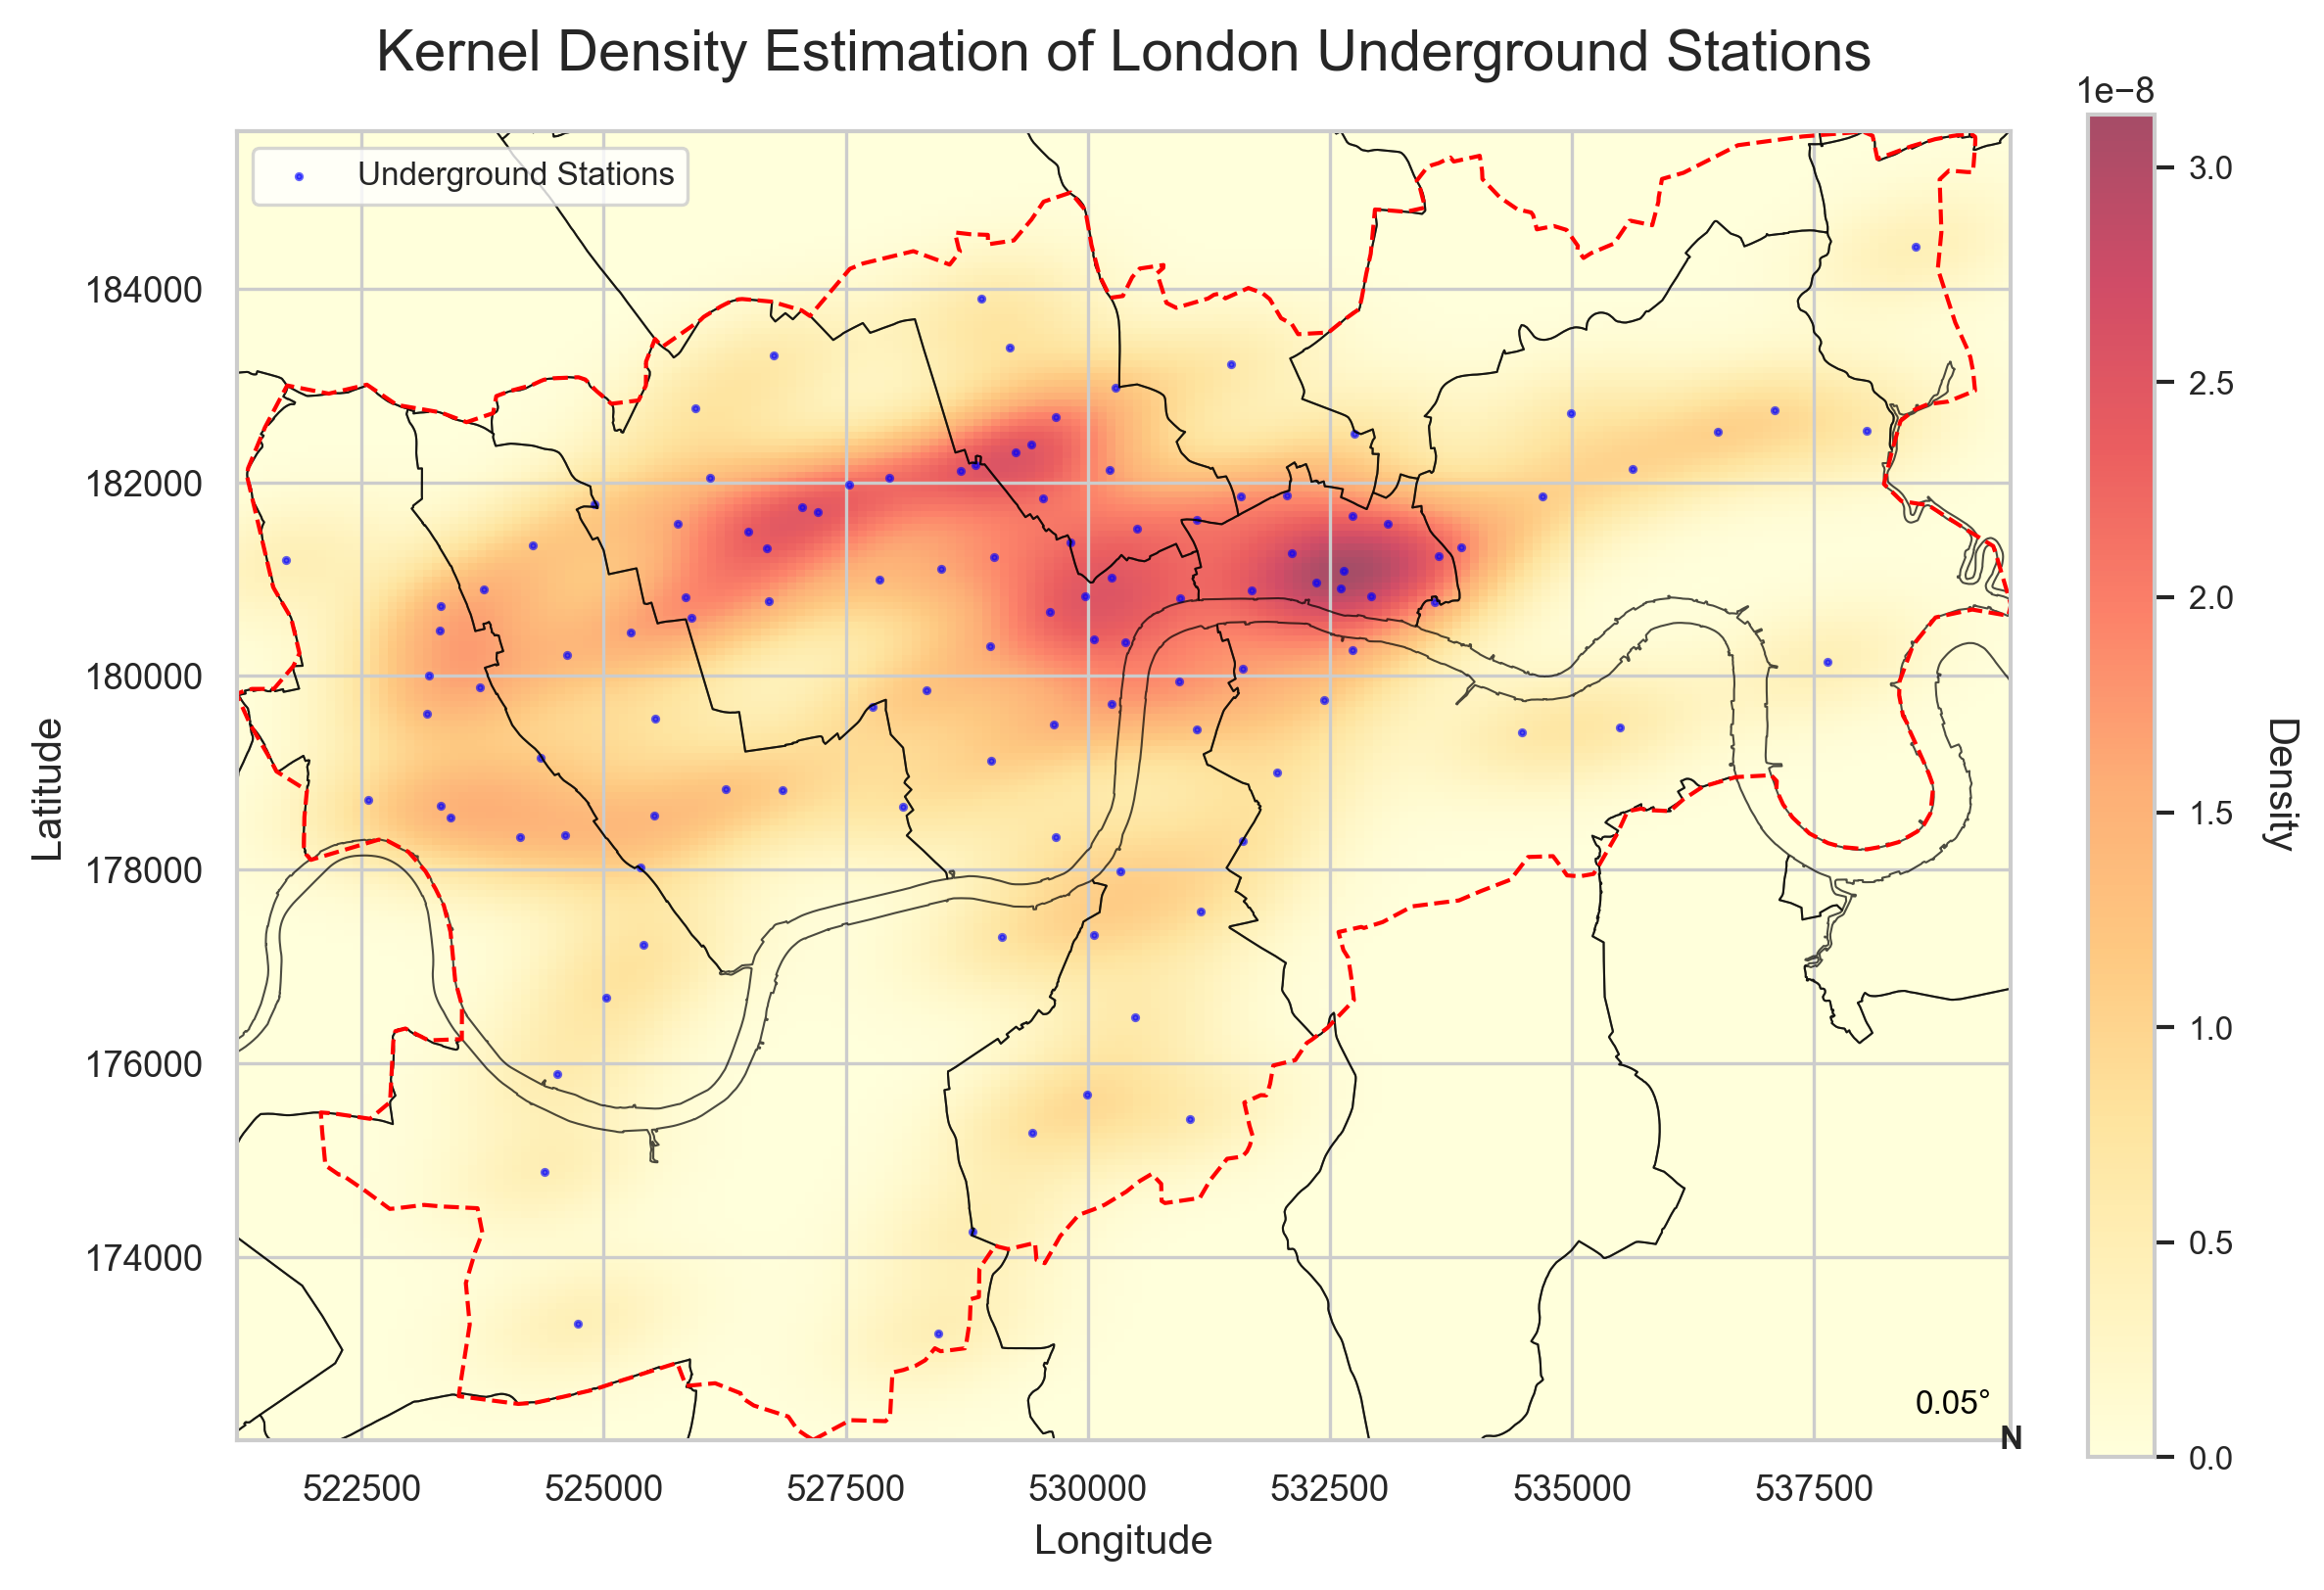

In [38]:
coordinates = np.array(list(points_metro.geometry.apply(lambda geom: (geom.x, geom.y))))

sns.set_style("whitegrid")
sns.set_context("paper")

x_min, y_min, x_max, y_max = scope.total_bounds

bandwidth = 0.2
kde = gaussian_kde(coordinates.T, bw_method=bandwidth)
x, y = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
positions = np.vstack([x.ravel(), y.ravel()])
density = kde(positions).reshape(x.shape)

fig, ax = plt.subplots(figsize=(8, 10), dpi=300)

im = ax.imshow(np.rot90(density), cmap='YlOrRd', extent=[x_min, x_max, y_min, y_max], alpha=0.7, aspect='auto')

ax.scatter(coordinates[:, 0], coordinates[:, 1], s=2, c='blue', alpha=0.6, label='Underground Stations')

london.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, alpha=0.7)
scope.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, linestyle='--')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_title('Kernel Density Estimation of London Underground Stations', fontsize=14, pad=15)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)

cbar = plt.colorbar(im, ax=ax, label='Density', fraction=0.035, pad=0.04)
cbar.ax.set_ylabel('Density', rotation=270, labelpad=15, fontsize=10)
cbar.ax.tick_params(labelsize=8)

fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(ax.transData,
                           0.05, 
                           '0.05°',
                           'lower right',
                           pad=0.5,
                           color='black',
                           frameon=False,
                           size_vertical=0.005,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

from matplotlib.patches import Arrow
arrow = Arrow(x_max - 0.03, y_min + 0.03, 0, 0.03, width=0.015, color='black')
ax.add_patch(arrow)
ax.text(x_max - 0.03, y_min + 0.07, 'N', ha='center', va='center', fontweight='bold', fontsize=8)

ax.legend(loc='upper left', frameon=True, fontsize=8)

plt.tight_layout()

plt.show()

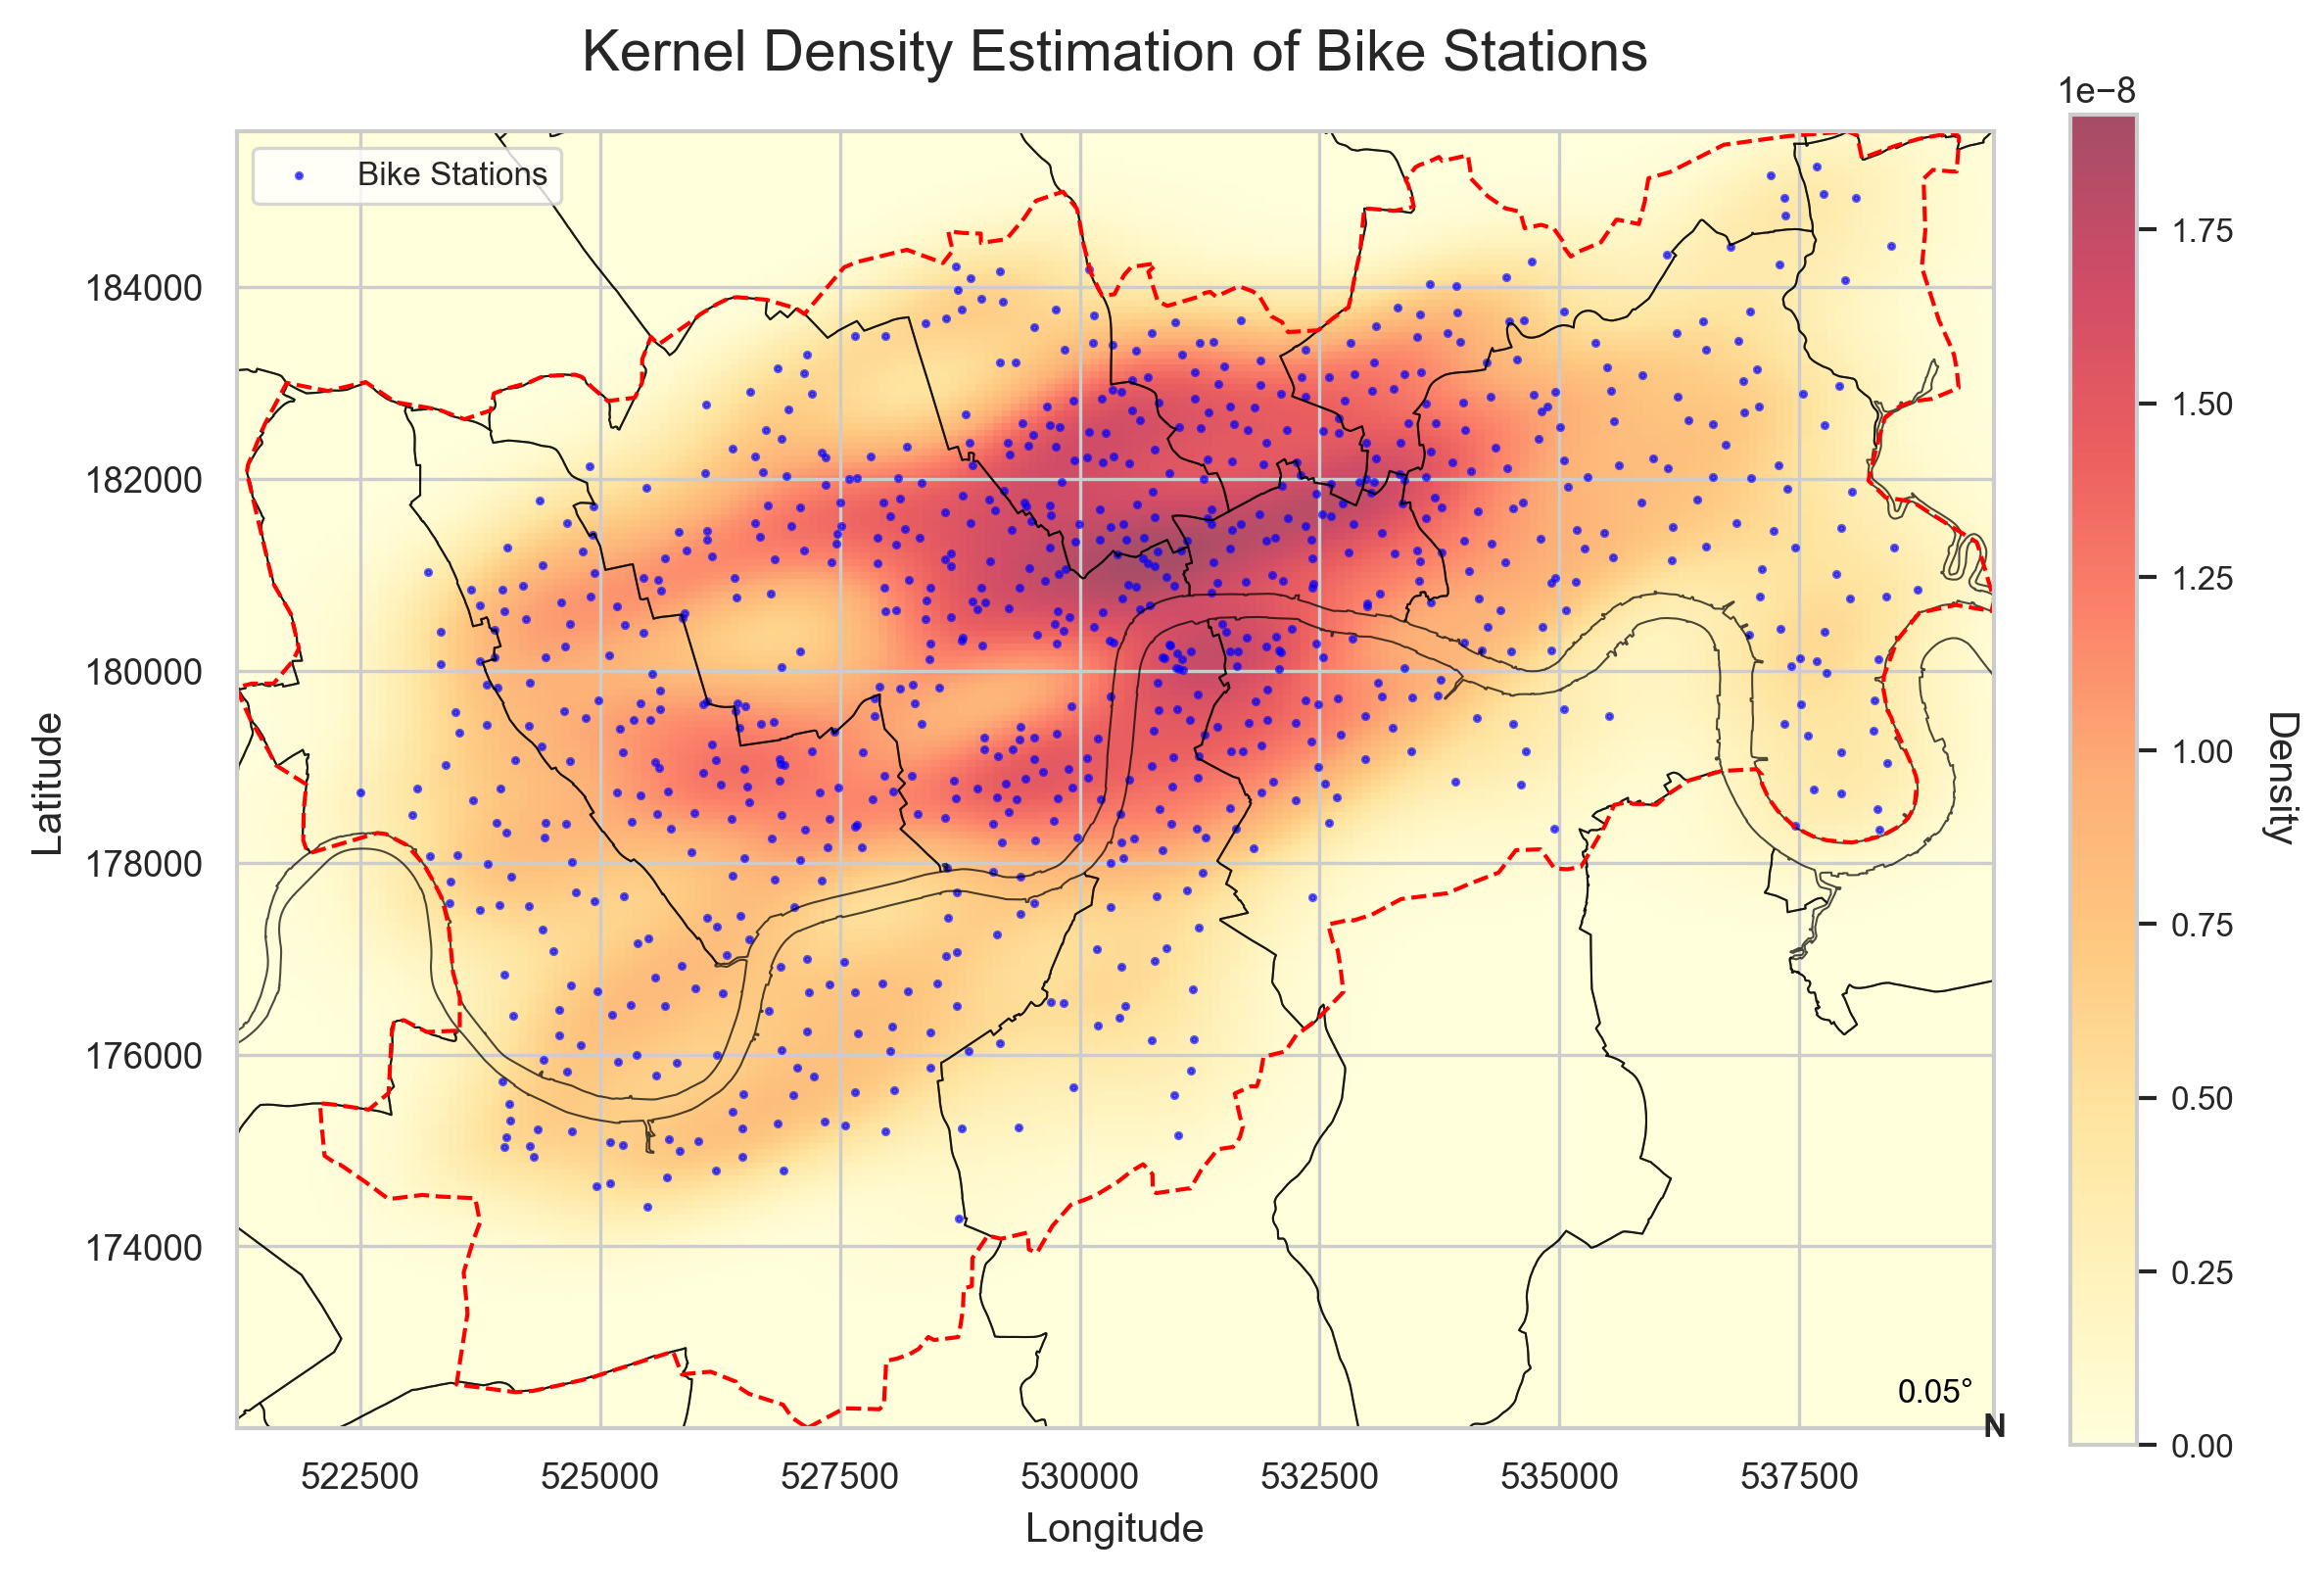

In [39]:
coordinates = np.array(list(bikestation.geometry.apply(lambda geom: (geom.x, geom.y))))

sns.set_style("whitegrid")
sns.set_context("paper")

x_min, y_min, x_max, y_max = scope.total_bounds

bandwidth = 0.2
kde = gaussian_kde(coordinates.T, bw_method=bandwidth)
x, y = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
positions = np.vstack([x.ravel(), y.ravel()])
density = kde(positions).reshape(x.shape)

fig, ax = plt.subplots(figsize=(8, 10), dpi=300)

im = ax.imshow(np.rot90(density), cmap='YlOrRd', extent=[x_min, x_max, y_min, y_max], alpha=0.7, aspect='auto')

ax.scatter(coordinates[:, 0], coordinates[:, 1], s=2, c='blue', alpha=0.6, label='Bike Stations')

london.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, alpha=0.7)
scope.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, linestyle='--')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_title('Kernel Density Estimation of Bike Stations', fontsize=14, pad=15)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)

cbar = plt.colorbar(im, ax=ax, label='Density', fraction=0.035, pad=0.04)
cbar.ax.set_ylabel('Density', rotation=270, labelpad=15, fontsize=10)
cbar.ax.tick_params(labelsize=8)

fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(ax.transData,
                           0.05, 
                           '0.05°',
                           'lower right',
                           pad=0.5,
                           color='black',
                           frameon=False,
                           size_vertical=0.005,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

from matplotlib.patches import Arrow
arrow = Arrow(x_max - 0.03, y_min + 0.03, 0, 0.03, width=0.015, color='black')
ax.add_patch(arrow)
ax.text(x_max - 0.03, y_min + 0.07, 'N', ha='center', va='center', fontweight='bold', fontsize=8)

ax.legend(loc='upper left', frameon=True, fontsize=8)

plt.tight_layout()

plt.show()

## Nearest neighbour

In [40]:
points_metro['nearest_bike'] = points_metro.geometry.apply(lambda x: bikestation.distance(x).min())

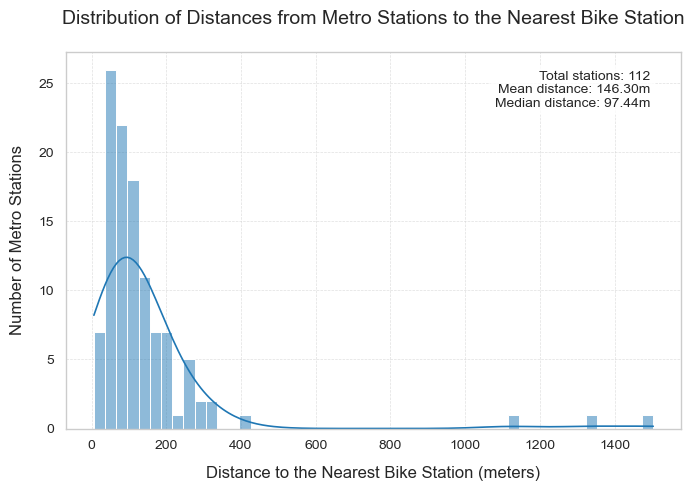

In [41]:
fig, ax = plt.subplots(figsize=(7, 5))

sns.histplot(points_metro['nearest_bike'], bins=50, kde=True, edgecolor='white', ax=ax)

ax.set_title('Distribution of Distances from Metro Stations to the Nearest Bike Station', fontsize=14, pad=20)
ax.set_xlabel('Distance to the Nearest Bike Station (meters)', fontsize=12, labelpad=10)
ax.set_ylabel('Number of Metro Stations', fontsize=12, labelpad=10)

ax.tick_params(axis='both', which='major', labelsize=10)

ax.grid(True, which='major', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

mean_distance = points_metro['nearest_bike'].mean()
median_distance = points_metro['nearest_bike'].median()

stats_text = f"Total stations: {len(points_metro)}\n" \
             f"Mean distance: {mean_distance:.2f}m\n" \
             f"Median distance: {median_distance:.2f}m"
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

plt.show()

In [42]:
def calculate_nearest_bike_coords(metro_row):
    distances = bikestation.distance(metro_row.geometry)
    nearest_index = distances.idxmin()
    nearest_bike_geom = bikestation.loc[nearest_index].geometry
    return nearest_bike_geom

points_metro['nearest_bike_coords'] = points_metro.apply(calculate_nearest_bike_coords, axis=1)

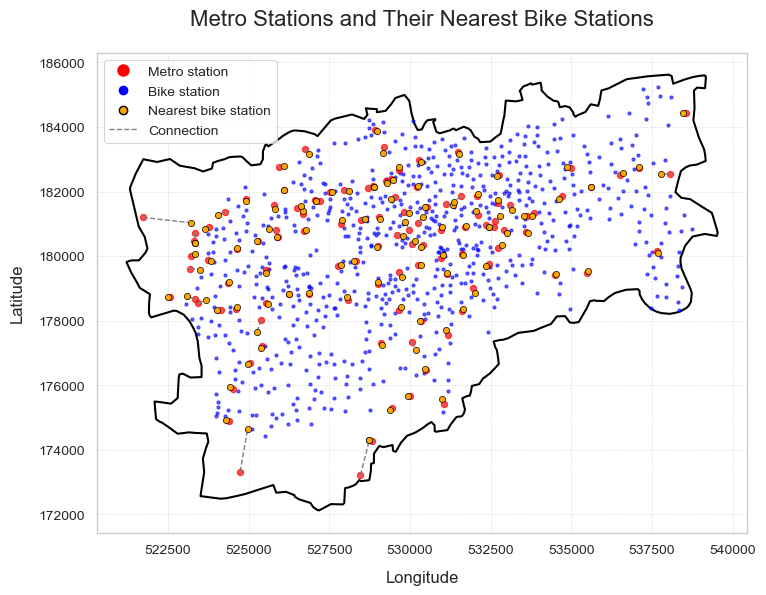

In [43]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(8, 6))

scope.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5, zorder=1)

bikestation.plot(ax=ax, color='blue', markersize=5, label='Bike station', alpha=0.6, zorder=2)
points_metro.plot(ax=ax, color='red', markersize=20, label='Metro station', alpha=0.7, zorder=3)

for idx, row in points_metro.iterrows():
    bike_geom = row['nearest_bike_coords']
    ax.plot([row.geometry.x, bike_geom.x], [row.geometry.y, bike_geom.y], 
            color='gray', linestyle='--', linewidth=1,  zorder=4)
    ax.scatter(bike_geom.x, bike_geom.y, color='orange', s=20, edgecolor='black', linewidth=0.5, zorder=5)

ax.set_title('Metro Stations and Their Nearest Bike Stations', fontsize=16, pad=20)
ax.set_xlabel('Longitude', fontsize=12, labelpad=10)
ax.set_ylabel('Latitude', fontsize=12, labelpad=10)

ax.tick_params(axis='both', which='major', labelsize=10)

ax.grid(True, which='major', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Metro station',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Bike station',
           markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Nearest bike station',
           markerfacecolor='orange', markersize=6, markeredgecolor='black'),
    Line2D([0], [0], color='gray', lw=1, linestyle='--', label='Connection')
]
ax.legend(handles=legend_elements, loc='best', fontsize=10)

plt.tight_layout()
plt.show()

## Bike connectivity index

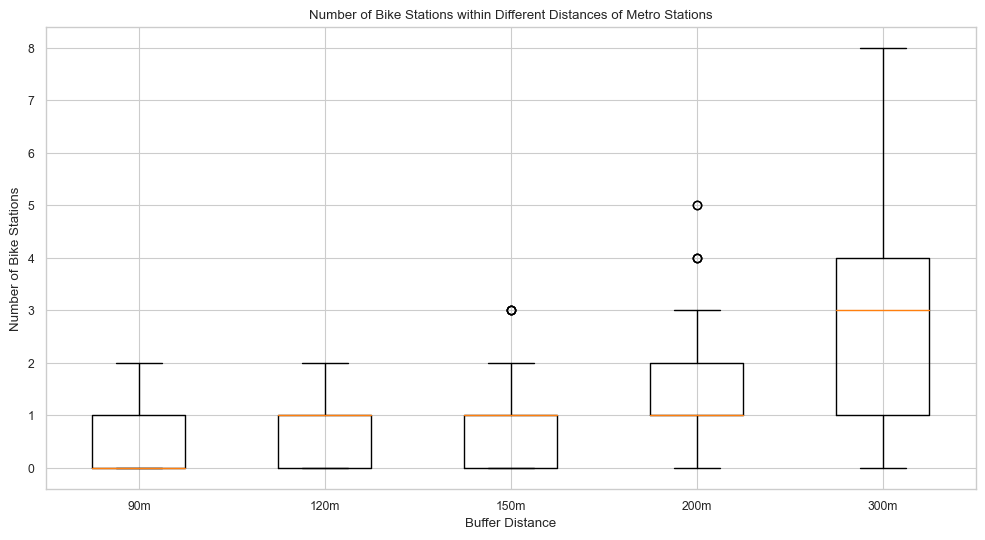

In [44]:
buffer_distances = [90, 120, 150, 200, 300] 
for distance in buffer_distances:
    points_metro[f'bikes_within_{distance}m'] = points_metro.geometry.apply(
        lambda x: sum(bikestation.distance(x) <= distance)
    )

plt.figure(figsize=(12, 6))
data = [points_metro[f'bikes_within_{d}m'] for d in buffer_distances]
plt.boxplot(data, labels=[f'{d}m' for d in buffer_distances])
plt.title('Number of Bike Stations within Different Distances of Metro Stations')
plt.xlabel('Buffer Distance')
plt.ylabel('Number of Bike Stations')
plt.show()

In [45]:
radii = [90, 120, 150]
weights = [1, 0.5, 0.2]

def calculate_weighted_capacity(metro_geom, radius, weight):
    buffer = metro_geom.buffer(radius)
    within_buffer = bikestation[bikestation.within(buffer)]
    total_capacity = within_buffer['NbDocks'].sum()
    weighted_capacity = total_capacity * weight
    
    return weighted_capacity

weighted_bike_indices = []

for index, metro_geom in points_metro.iterrows():
    weighted_sum = 0
    for radius, weight in zip(radii, weights):
        weighted_sum += calculate_weighted_capacity(metro_geom.geometry, radius, weight)
    weighted_bike_indices.append(weighted_sum)

points_metro['bike_connectivity_index'] = weighted_bike_indices
points_metro['bike_connectivity_index'] = points_metro['bike_connectivity_index']/1.7

print(points_metro[['bike_connectivity_index']].head())

   bike_connectivity_index
0                27.000000
1                 4.000000
2                19.000000
3                17.529412
4                 0.000000


In [46]:
points_metro['bike_connectivity_index'].describe(percentiles=[.05, .25, .5, .75, .95])

count    112.000000
mean      17.285714
std       18.053011
min        0.000000
5%         0.000000
25%        0.000000
50%       15.000000
75%       27.220588
95%       49.258824
max       83.000000
Name: bike_connectivity_index, dtype: float64

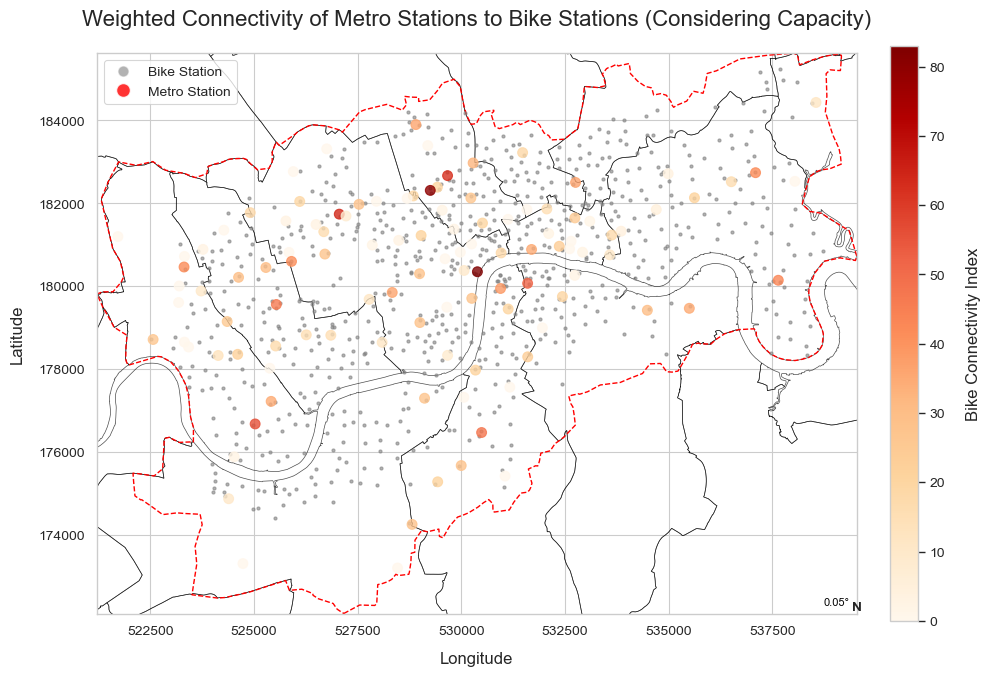

In [47]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 8))

x_min, y_min, x_max, y_max = scope.total_bounds

london.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, alpha=0.7)
scope.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, linestyle='--')

bikestation.plot(ax=ax, color='grey', markersize=5, alpha=0.6, label='Bike Station')

scatter = points_metro.plot(ax=ax, column='bike_connectivity_index', cmap='OrRd', 
                            markersize=50, legend=False, alpha=0.8)

sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=points_metro['bike_connectivity_index'].min(), 
                                                           vmax=points_metro['bike_connectivity_index'].max()))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label('Bike Connectivity Index', fontsize=12, labelpad=15)
cbar.ax.tick_params(labelsize=10)

ax.set_title('Weighted Connectivity of Metro Stations to Bike Stations (Considering Capacity)', fontsize=16, pad=20)
ax.set_xlabel('Longitude', fontsize=12, labelpad=10)
ax.set_ylabel('Latitude', fontsize=12, labelpad=10)

ax.tick_params(axis='both', which='major', labelsize=10)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Bike Station',
           markerfacecolor='grey', markersize=8, alpha=0.6),
    Line2D([0], [0], marker='o', color='w', label='Metro Station',
           markerfacecolor='red', markersize=10, alpha=0.8)
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(ax.transData,
                           0.05, 
                           '0.05°',
                           'lower right',
                           pad=0.5,
                           color='black',
                           frameon=False,
                           size_vertical=0.005,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

from matplotlib.patches import Arrow
arrow = Arrow(x_max - 0.03, y_min + 0.03, 0, 0.03, width=0.015, color='black')
ax.add_patch(arrow)
ax.text(x_max - 0.03, y_min + 0.07, 'N', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

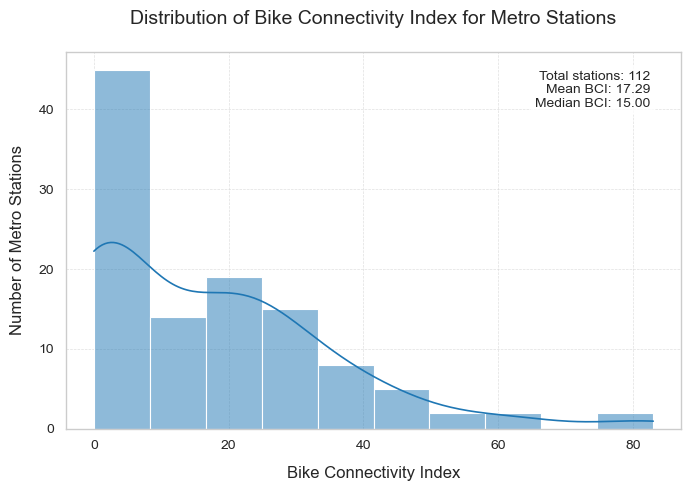

Metro stations with highest BCI:
                                            name  bike_connectivity_index
31                Embankment Underground Station                83.000000
108            Warren Street Underground Station                80.000000
33   Edgware Road (Bakerloo) Underground Station                64.000000
36                    Euston Underground Station                62.352941
77             Parsons Green Underground Station                56.000000
95                 Southwark Underground Station                51.588235
91                 Stockwell Underground Station                47.352941
49    High Street Kensington Underground Station                46.529412
27              Canary Wharf Underground Station                43.411765
15                  Bow Road Underground Station                42.000000

Metro stations with lowest BCI:
                                                 name  bike_connectivity_index
4                  Bromley-by-Bow Undergr

In [48]:
fig, ax = plt.subplots(figsize=(7, 5))

sns.histplot(points_metro['bike_connectivity_index'], bins=10, kde=True, edgecolor='white', ax=ax)

ax.set_title('Distribution of Bike Connectivity Index for Metro Stations', fontsize=14, pad=20)
ax.set_xlabel('Bike Connectivity Index', fontsize=12, labelpad=10)
ax.set_ylabel('Number of Metro Stations', fontsize=12, labelpad=10)

ax.tick_params(axis='both', which='major', labelsize=10)

ax.grid(True, which='major', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

mean_BCI = points_metro['bike_connectivity_index'].mean()
median_BCI = points_metro['bike_connectivity_index'].median()

stats_text = f"Total stations: {len(points_metro)}\n" \
             f"Mean BCI: {mean_BCI:.2f}\n" \
             f"Median BCI: {median_BCI:.2f}"
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

plt.show()

print("Metro stations with highest BCI:")
print(points_metro.nlargest(10, 'bike_connectivity_index')[['name', 'bike_connectivity_index']])
print("\nMetro stations with lowest BCI:")
print(points_metro.nsmallest(30, 'bike_connectivity_index')[['name', 'bike_connectivity_index']])

In [49]:
points_metro['bike_connectivity_index'].describe(percentiles=[.05, .25, .5, .75, .95])

count    112.000000
mean      17.285714
std       18.053011
min        0.000000
5%         0.000000
25%        0.000000
50%       15.000000
75%       27.220588
95%       49.258824
max       83.000000
Name: bike_connectivity_index, dtype: float64

In [50]:
# Calculate the sum of the capacity of bike stations within a specified radius
def calculate_total_capacity(metro_geom, radius):
    buffer = metro_geom.buffer(radius)
    within_buffer = bikestation[bikestation.within(buffer)]
    capacity = 0
    capacity = within_buffer['NbDocks'].sum()
    return capacity

def calculate_total_bikestop(metro_geom, radius):
    buffer = metro_geom.buffer(radius)
    within_buffer = bikestation[bikestation.within(buffer)]
    bikestop = 0
    bikestop = within_buffer.shape[0]
    return bikestop

total_capacity_150 = []
bikestop_150 = []

for index, metro_geom in points_metro.iterrows():
    capacity_sum = calculate_total_capacity(metro_geom.geometry, 150)
    bikestop = calculate_total_bikestop(metro_geom.geometry, 150)
    total_capacity_150.append(capacity_sum)
    bikestop_150.append(bikestop)

points_metro['total_capacity_150'] = total_capacity_150
points_metro['bikestop_150'] = bikestop_150

# Actual Usage Effects

## Identify Metro-BSS Trips

In [51]:
bikeinmetrobuffer = gpd.read_file("https://github.com/tianzhhai/dissertation/raw/main/bikeinmetrobuffer150.geojson")

In [52]:
bikeinmetrobuffer['name'].nunique()

103

In [53]:
df_spatial_Oc = df_spatial[df_spatial['Month']==10]

In [54]:
tripinbuffer = df_spatial_Oc[df_spatial_Oc['Start_station'].isin(bikeinmetrobuffer['name'])]
tripinbuffer.shape

(152663, 18)

#### Calculate direction of trips

In [55]:
def calculate_direction(station_coord, start_coord, end_coord):
    trip_vector = np.array(end_coord) - np.array(start_coord)
    reference_vector = np.array(start_coord) - np.array(station_coord)
    
    cos_angle = np.dot(trip_vector, reference_vector) / (np.linalg.norm(trip_vector) * np.linalg.norm(reference_vector))
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0)) * 180 / np.pi
    
    if angle < 90:
        return "Away from station"
    elif angle > 90:
        return "Towards station"
    else:
        return "Perpendicular to station"

In [56]:
tripinbuffer = tripinbuffer.merge(bikeinmetrobuffer[['name', 'name_2','POPDEN']], left_on='Start_station', right_on='name',how = 'left')

tripinbuffer = tripinbuffer.merge(bikestation[['name', 'geometry']], 
                          left_on='Start_station', right_on='name')
tripinbuffer = tripinbuffer.rename(columns={'geometry': 'start_geometry'})

tripinbuffer = tripinbuffer.merge(bikestation[['name', 'geometry']], 
                          left_on='End_station', right_on='name')
tripinbuffer = tripinbuffer.rename(columns={'geometry': 'end_geometry'})

tripinbuffer.drop(columns=['name_x'], inplace=True)

tripinbuffer = tripinbuffer.merge(points_metro[['name', 'geometry']], 
                          left_on='name_2', right_on='name')
tripinbuffer = tripinbuffer.rename(columns={'geometry': 'metro_geometry'})

tripinbuffer['start_coord'] = tripinbuffer['start_geometry'].apply(lambda point: (point.x, point.y))
tripinbuffer['end_coord'] = tripinbuffer['end_geometry'].apply(lambda point: (point.x, point.y))
tripinbuffer['metro_coord'] = tripinbuffer['metro_geometry'].apply(lambda point: (point.x, point.y))

tripinbuffer['Direction'] = tripinbuffer.apply(lambda row: calculate_direction(
    row['metro_coord'], row['start_coord'], row['end_coord']), axis=1)

#### Identify Metro-BSS Trips

In [57]:
tripinbufferop = tripinbuffer[tripinbuffer['Hour'] > 4].copy()

muti = tripinbufferop[(tripinbufferop['Duration'] < 1800) & (tripinbufferop['Duration'] > 0) & (tripinbufferop['Direction']!='Towards station')].copy()
muti.shape

(76642, 30)

In [58]:
76642/152663

0.5020338916436857

## Spatio-temporal patterns

#### Calculate the number of Metro-BSS trips by hour for each day of the week

In [59]:
trip_counts = muti.groupby(['Weekday', 'Hour']).size().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
trip_counts.loc['Monday'] /= 5
trip_counts.loc['Saturday'] /= 5
trip_counts.loc['Sunday'] /= 5
trip_counts.loc['Tuesday'] /= 4
trip_counts.loc['Wednesday'] /= 4
trip_counts.loc['Friday'] /= 4
trip_counts.loc['Thursday'] /= 4
trip_counts.insert(0, 0, 0.0) 
trip_counts.insert(1, 1, 0.0)  
trip_counts.insert(2, 2, 0.0)  
trip_counts.insert(3, 3, 0.0)  
trip_counts.insert(4, 4, 0.0)
trip_counts 

Hour        0    1    2    3    4     5      6       7       8       9   ...  \
Weekday                                                                  ...   
Monday     0.0  0.0  0.0  0.0  0.0  9.40  69.00  201.20  340.00  179.80  ...   
Tuesday    0.0  0.0  0.0  0.0  0.0  9.00  99.75  310.50  432.50  232.75  ...   
Wednesday  0.0  0.0  0.0  0.0  0.0  5.75  66.50  237.00  388.50  222.25  ...   
Thursday   0.0  0.0  0.0  0.0  0.0  6.25  87.00  271.25  400.00  203.25  ...   
Friday     0.0  0.0  0.0  0.0  0.0  9.75  67.75  175.25  303.25  150.00  ...   
Saturday   0.0  0.0  0.0  0.0  0.0  7.00  13.80   19.40   36.80   71.60  ...   
Sunday     0.0  0.0  0.0  0.0  0.0  9.20  13.80   13.60   24.00   48.60  ...   

Hour           14      15      16      17      18      19     20      21  \
Weekday                                                                    
Monday      98.80  120.20  160.00  257.20  296.60  182.60  119.8   81.60   
Tuesday    112.00  114.50  159.50  330.75  383.25  223.75  133.0  100.75   
Wednesday   92.25  109.50  148.00  283.50  312.25  204.75  128.5  101.00   
Thursday    92.50  113.50  152.00  299.75  314.00  214.25  130.0   98.00   
Friday     110.75  132.75  178.25  223.75  196.50  127.25  101.0   81.00   
Saturday   165.80  163.00  177.20  174.20  160.20  136.80   92.6   71.80   
Sunday     139.60  144.00  157.00  139.20  120.40   83.40   64.4   50.40   

Hour           22     23  
Weekday                   
Monday      62.40  35.80  
Tuesday     98.00  49.25  
Wednesday   97.25  65.50  
Thursday   107.50  75.00  
Friday      82.00  70.25  
Saturday    73.80  69.00  
Sunday      33.60  25.80  

[7 rows x 24 columns]

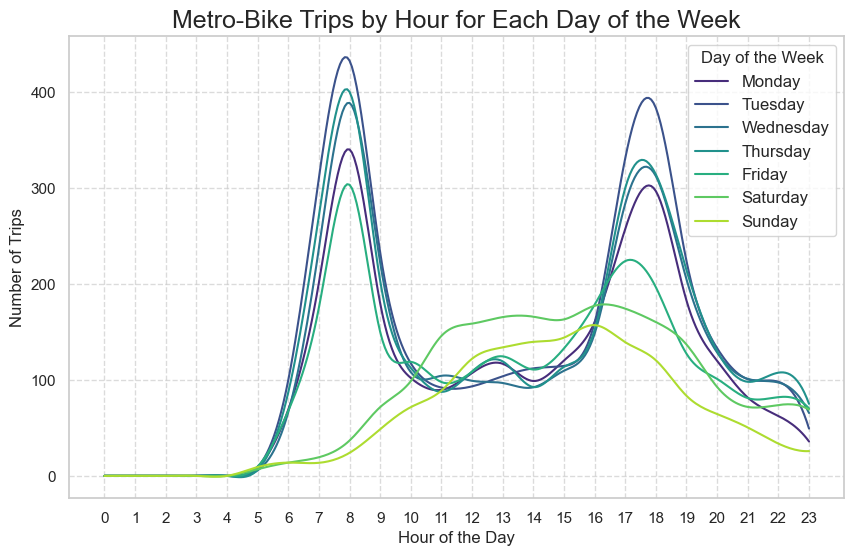

In [60]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

colors = sns.color_palette("viridis", 7)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, day in enumerate(days):
    x = trip_counts.columns.values
    y = trip_counts.loc[day].values
    
    x_new = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=3) 
    y_smooth = spl(x_new)
    
    plt.plot(x_new, y_smooth, label=day, color=colors[i])
    
plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Metro-Bike Trips by Hour for Each Day of the Week',fontsize=18)
plt.xlabel('Hour of the Day',fontsize=12)
plt.ylabel('Number of Trips',fontsize=12)
plt.legend(title='Day of the Week',fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)

plt.show()

#### Calculate the number of all BSS trips starting in metro buffer (150m) by hour for each day of the week

In [61]:
total_trip_counts = tripinbuffer.groupby(['Weekday', 'Hour']).size().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
total_trip_counts.loc['Monday'] /= 5
total_trip_counts.loc['Saturday'] /= 5
total_trip_counts.loc['Sunday'] /= 5
total_trip_counts.loc['Tuesday'] /= 4
total_trip_counts.loc['Wednesday'] /= 4
total_trip_counts.loc['Friday'] /= 4
total_trip_counts.loc['Thursday'] /= 4

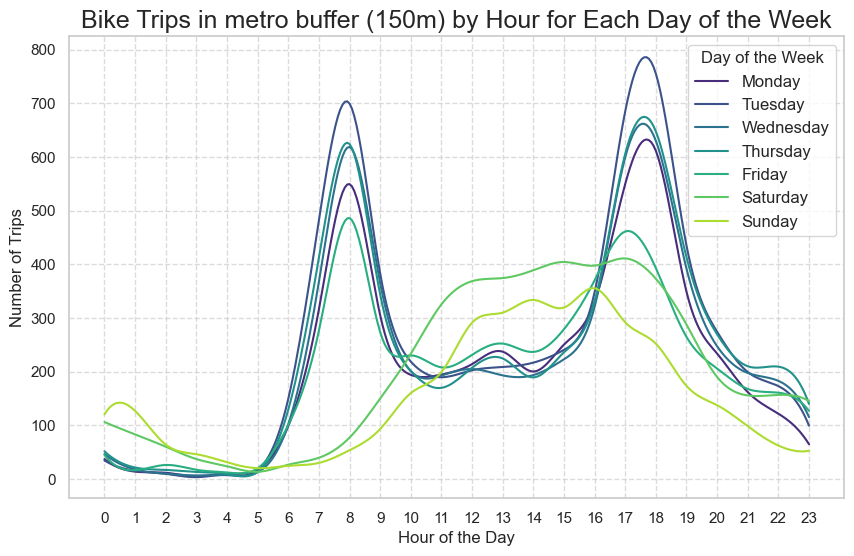

In [62]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

colors = sns.color_palette("viridis", 7)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, day in enumerate(days):
    x = total_trip_counts.columns.values
    y = total_trip_counts.loc[day].values
    
    x_new = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=3)
    y_smooth = spl(x_new)
    
    plt.plot(x_new, y_smooth, label=day, color=colors[i])
    
plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Bike Trips in metro buffer (150m) by Hour for Each Day of the Week',fontsize=18)
plt.xlabel('Hour of the Day',fontsize=12)
plt.ylabel('Number of Trips',fontsize=12)
plt.legend(title='Day of the Week',fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)

plt.show()

#### Calculate MTR by hour for each day of the week

In [63]:
mtr = trip_counts/total_trip_counts

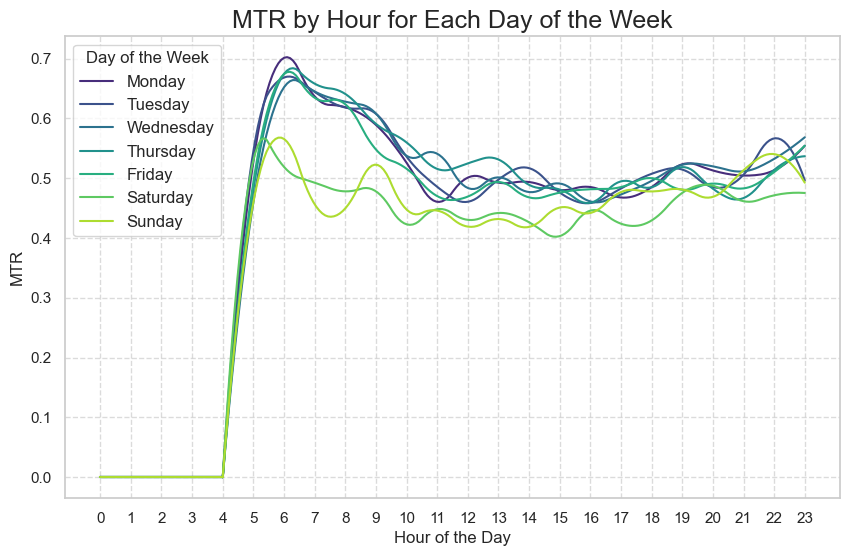

In [64]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", 7)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, day in enumerate(days):
    x = mtr.columns.values
    y = mtr.loc[day].values
    
    x_below_4 = x[x <= 4]
    y_below_4 = y[x <= 4]
    x_above_4 = x[x >= 4]
    y_above_4 = y[x >= 4]
    
    plt.plot(x_below_4, y_below_4, color=colors[i])
    
    if len(x_above_4) > 0:
        x_new = np.linspace(x_above_4.min(), x_above_4.max(), 200)
        spl = make_interp_spline(x_above_4, y_above_4, k=2)
        y_smooth = spl(x_new)
        plt.plot(x_new, y_smooth, label=day, color=colors[i])

plt.grid(True, linestyle='--', alpha=0.7)
plt.title('MTR by Hour for Each Day of the Week', fontsize=18)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('MTR', fontsize=12)
plt.legend(title='Day of the Week', fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.show()

In [65]:
hourly_frequencies = muti.groupby(['name_2', 'Start_station', 'Hour']).size().reset_index(name='frequency')
hourly_frequencies.sample(10)

name_2  \
819    Kensington (Olympia) Underground Station   
1175             Old Street Underground Station   
1073               Mile End Underground Station   
1798        Westbourne Park Underground Station   
499              Embankment Underground Station   
577                  Euston Underground Station   
638         Gloucester Road Underground Station   
669   Great Portland Street Underground Station   
880           Knightsbridge Underground Station   
1094               Monument Underground Station   

                                  Start_station  Hour  frequency  
819         Kensington Olympia Station, Olympia    10         37  
1175                 Baldwin Street, St. Luke's    19         42  
1073                    Maplin Street, Mile End     6          1  
1798               The Metropolitan, Portobello    14         26  
499                     Whitehall Place, Strand     6          3  
577               Euston Square Gardens, Euston    10         10  
638   Gloucester Road Station, South Kensington    15         55  
669                  Bolsover Street, Fitzrovia    11         46  
880               Seville Street, Knightsbridge    15         49  
1094                  Monument Street, Monument    10          7

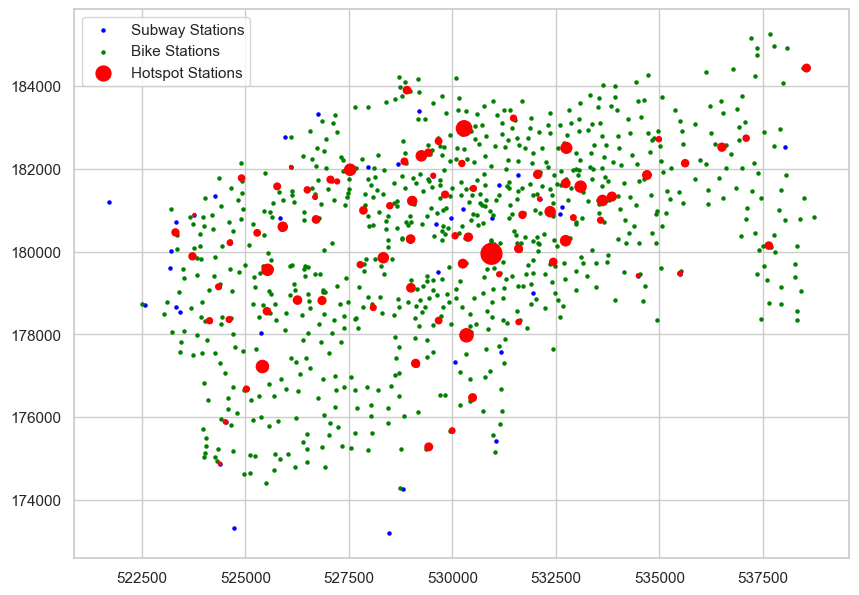

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))

metro.plot(ax=ax, color='blue', markersize=5, label='Subway Stations')

bikestation.plot(ax=ax, color='green', markersize=5, label='Bike Stations')

hotspot_frequencies = muti.groupby('name_2').size().reset_index(name='frequency')
hotspot_gdf = points_metro[points_metro['name'].isin(hotspot_frequencies['name_2'])]
hotspot_gdf = hotspot_gdf.merge(hotspot_frequencies[['name_2', 'frequency']], left_on='name', right_on='name_2')

hotspot_gdf.plot(ax=ax, color='red', markersize=hotspot_gdf['frequency']/30, label='Hotspot Stations')

plt.legend()
plt.show()

## Tensor decomposition

### Tensor decomposition for Metro-BSS trip count

In [67]:
td = muti[['name_2','Start_date']].copy()

In [68]:
td['Start_date'] = pd.to_datetime(td['Start_date'])

In [69]:
td['weekday'] = td['Start_date'].dt.weekday
td['day'] = td['Start_date'].dt.day
td['period'] = td['Start_date'].dt.hour

In [70]:
unique_stations = td['name_2'].unique()
station_map = {station: idx for idx, station in enumerate(unique_stations)}
td['id'] = td['name_2'].map(station_map)

In [71]:
tensor_shape = (7, 19, len(unique_stations))
X1 = np.zeros(tensor_shape)

In [72]:
day_count = td.groupby('weekday')['day'].nunique()

In [73]:
for row in td.itertuples():
    day_idx = row.weekday
    time_idx = row.period
    station_idx = row.id
    if pd.notna(time_idx): 
        X1[day_idx, int(time_idx - 5), station_idx] += 1 

In [74]:
for day_idx in range(7):
    X1[day_idx, :, :] /= day_count[day_idx]

In [75]:
X1.shape

(7, 19, 80)

In [76]:
ranks = [2, 5, 10]

core, factors = non_negative_tucker(X1, rank=ranks)

print("Core tensor shape:", core.shape)
print("Factors shapes:", [f.shape for f in factors])

Core tensor shape: (2, 5, 10)
Factors shapes: [(7, 2), (19, 5), (80, 10)]


In [77]:
A1, B1, C1 = factors

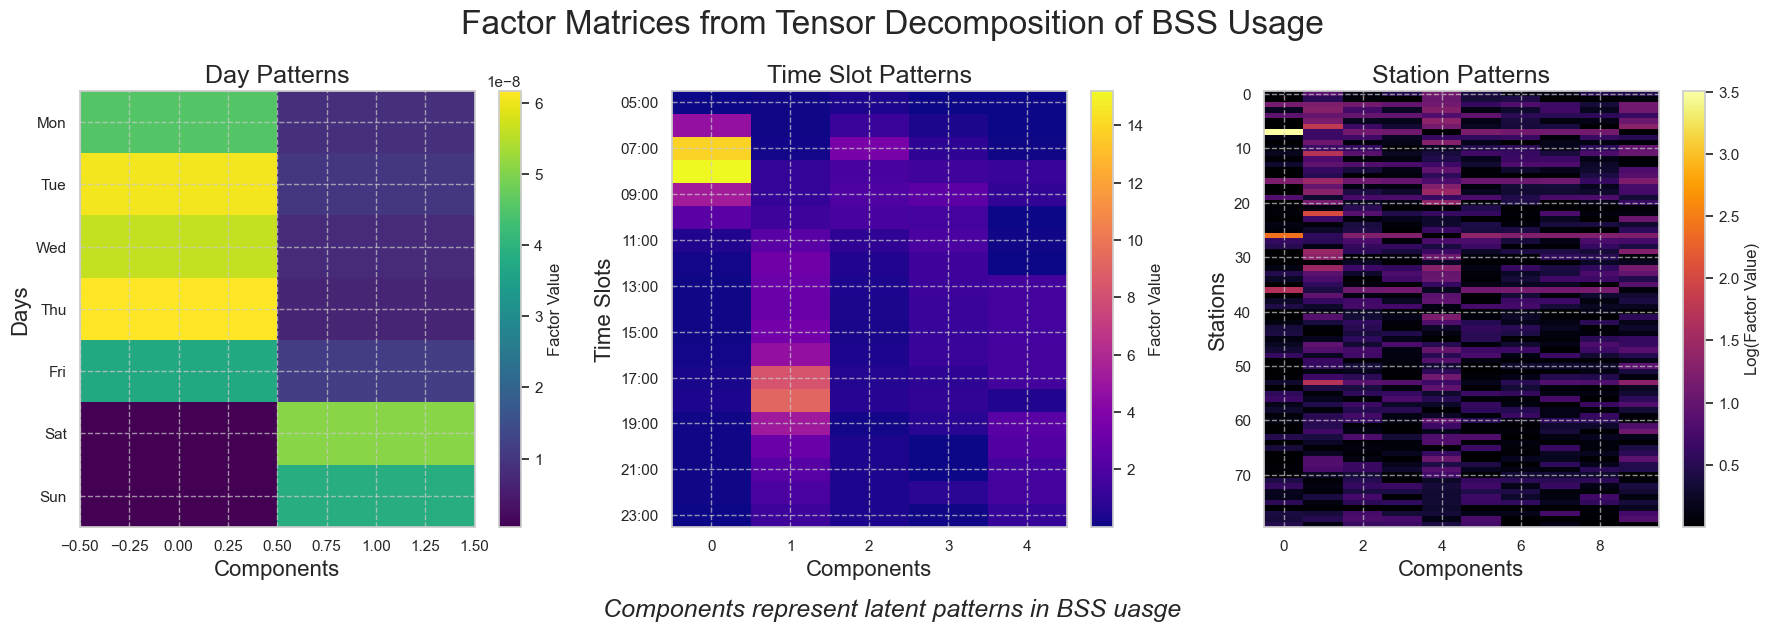

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

im1 = ax1.imshow(A1, aspect='auto', cmap='viridis')
ax1.set_title('Day Patterns', fontsize=18)
ax1.set_xlabel('Components', fontsize=16)
ax1.set_ylabel('Days', fontsize=16)
fig.colorbar(im1, ax=ax1, label='Factor Value')

im2 = ax2.imshow(B1, aspect='auto', cmap='plasma')
ax2.set_title('Time Slot Patterns', fontsize=18)
ax2.set_xlabel('Components', fontsize=16)
ax2.set_ylabel('Time Slots', fontsize=16)
fig.colorbar(im2, ax=ax2, label='Factor Value')

# im3 = ax3.imshow(C1, aspect='auto', cmap='inferno')
im3 = ax3.imshow(np.log1p(C1), aspect='auto', cmap='inferno')
ax3.set_title('Station Patterns', fontsize=18)
ax3.set_xlabel('Components', fontsize=16)
ax3.set_ylabel('Stations', fontsize=16)
fig.colorbar(im3, ax=ax3, label='Log(Factor Value)')

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax1.set_yticks(range(len(days)))
ax1.set_yticklabels(days)

time_slots = [f'{i+5:02d}:00' for i in range(20)]
ax2.set_yticks(range(0, len(time_slots), 2))
ax2.set_yticklabels(time_slots[::2])

fig.text(0.5, -0.02, 'Components represent latent patterns in BSS uasge', 
         ha='center', va='center', fontsize=18, style='italic')

for ax in (ax1, ax2, ax3):
    ax.grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Factor Matrices from Tensor Decomposition of BSS Usage', fontsize=24)
plt.tight_layout()
plt.show()

In [79]:
station_scores = np.sum(C1, axis=1)
top_stations = np.argsort(station_scores)[::-1][:5]
print("Top 5 potential multi-modal transport hubs (station indices):")
print(top_stations)

Top 5 potential multi-modal transport hubs (station indices):
[ 7 26 16 36  2]


In [80]:
station_map

{'Southwark Underground Station': 0,
 'Bond Street Underground Station': 1,
 'Liverpool Street Underground Station': 2,
 'Warren Street Underground Station': 3,
 'London Bridge Underground Station': 4,
 'Oxford Circus Underground Station': 5,
 'Mansion House Underground Station': 6,
 'Waterloo Underground Station': 7,
 'Stockwell Underground Station': 8,
 'Mile End Underground Station': 9,
 'Borough Underground Station': 10,
 'Old Street Underground Station': 11,
 'Charing Cross Underground Station': 12,
 'Embankment Underground Station': 13,
 'Clapham Common Underground Station': 14,
 'Russell Square Underground Station': 15,
 'Vauxhall Underground Station': 16,
 'Green Park Underground Station': 17,
 'Hyde Park Corner Underground Station': 18,
 'Victoria Underground Station': 19,
 'Westminster Underground Station': 20,
 'Bermondsey Underground Station': 21,
 'High Street Kensington Underground Station': 22,
 'Monument Underground Station': 23,
 'Lambeth North Underground Station': 24

In [81]:
day_pattern = np.argmax(A1, axis=1)
time_pattern = np.argmax(B1, axis=1)

print("\nDominant pattern for each day:")
for day, pattern in enumerate(day_pattern):
    print(f"Day {day+1}: Pattern {pattern+1}")

print("\nDominant pattern for each time slot:")
for slot, pattern in enumerate(time_pattern):
    print(f"Time slot {slot+1}: Pattern {pattern+1}")


Dominant pattern for each day:
Day 1: Pattern 1
Day 2: Pattern 1
Day 3: Pattern 1
Day 4: Pattern 1
Day 5: Pattern 1
Day 6: Pattern 2
Day 7: Pattern 2

Dominant pattern for each time slot:
Time slot 1: Pattern 3
Time slot 2: Pattern 1
Time slot 3: Pattern 1
Time slot 4: Pattern 1
Time slot 5: Pattern 1
Time slot 6: Pattern 1
Time slot 7: Pattern 2
Time slot 8: Pattern 2
Time slot 9: Pattern 2
Time slot 10: Pattern 2
Time slot 11: Pattern 2
Time slot 12: Pattern 2
Time slot 13: Pattern 2
Time slot 14: Pattern 2
Time slot 15: Pattern 2
Time slot 16: Pattern 2
Time slot 17: Pattern 2
Time slot 18: Pattern 2
Time slot 19: Pattern 2


### Tensor decomposition for MTR

In [82]:
def aggregate_trips(df):
    return df.groupby(['Day_of_week', 'hour', 'name_2']).size().unstack(fill_value=0)

In [83]:
muti['hour'] = muti['Hour'] - 5
tripinbufferop.loc[:, 'hour'] = tripinbufferop['Hour'] - 5
all_trips_agg = aggregate_trips(tripinbufferop)
muti_trips_agg = aggregate_trips(muti)

In [84]:
ratio = muti_trips_agg / all_trips_agg
ratio = ratio.fillna(0)

In [85]:
stations = ratio.columns.tolist()
num_stations = len(stations)

In [86]:
result = np.zeros((7, 19, num_stations))

for day in range(7):
    for hour_idx, hour in enumerate(range(0, 19)): 
        for station_idx, station in enumerate(stations):
            try:
                result[day, hour_idx, station_idx] = ratio.loc[(day, hour), station]
            except KeyError:
                result[day, hour_idx, station_idx] = 0

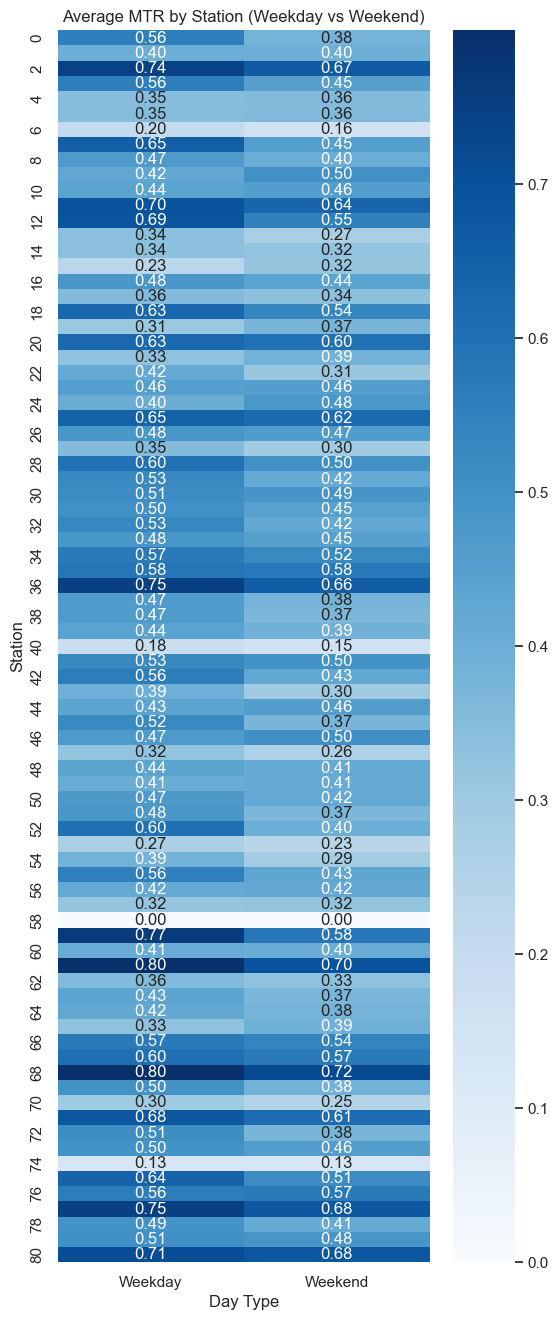

In [87]:
weekday_avg = np.mean(result[:5], axis=(0,1))
weekend_avg = np.mean(result[5:], axis=(0,1))

plt.figure(figsize=(6, 16))
sns.heatmap(pd.DataFrame({'Weekday': weekday_avg, 'Weekend': weekend_avg}), 
            annot=True, fmt='.2f', cmap='Blues')
plt.title('Average MTR by Station (Weekday vs Weekend)')
plt.xlabel('Day Type')
plt.ylabel('Station')
plt.show()

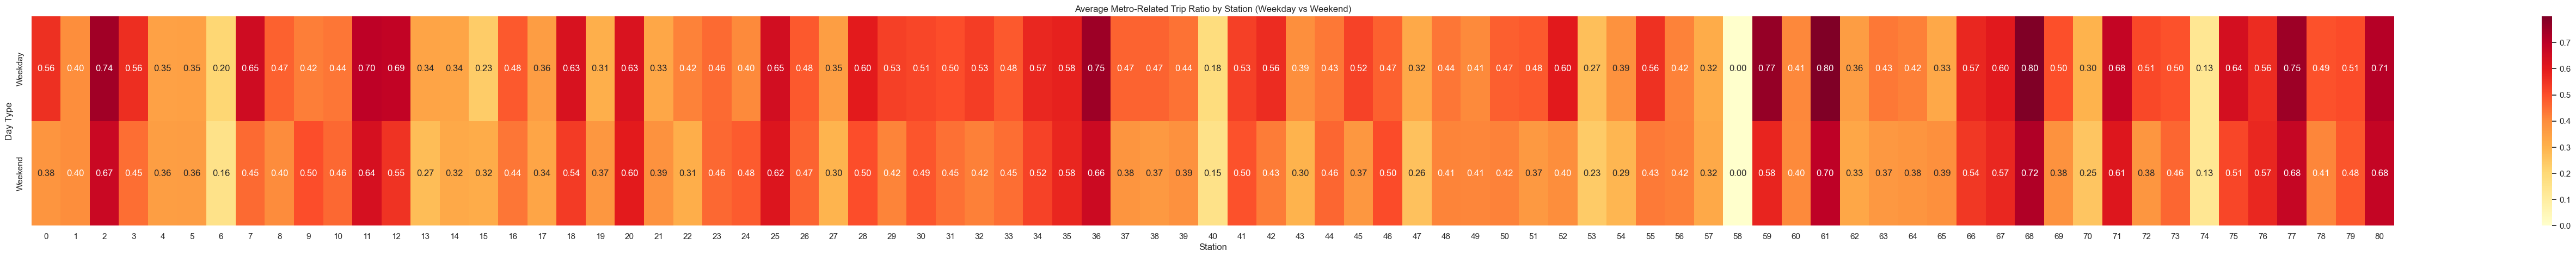

In [88]:
data = pd.DataFrame({'Weekday': weekday_avg, 'Weekend': weekend_avg}).T

plt.figure(figsize=(70, 5))
sns.heatmap(data, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Average Metro-Related Trip Ratio by Station (Weekday vs Weekend)')
plt.xlabel('Station')
plt.ylabel('Day Type')
plt.show()

In [89]:
rank = [2, 5, 10]

core, factors = non_negative_tucker(result, rank=rank, n_iter_max=100, random_state=42)

A2, B2, C2 = factors

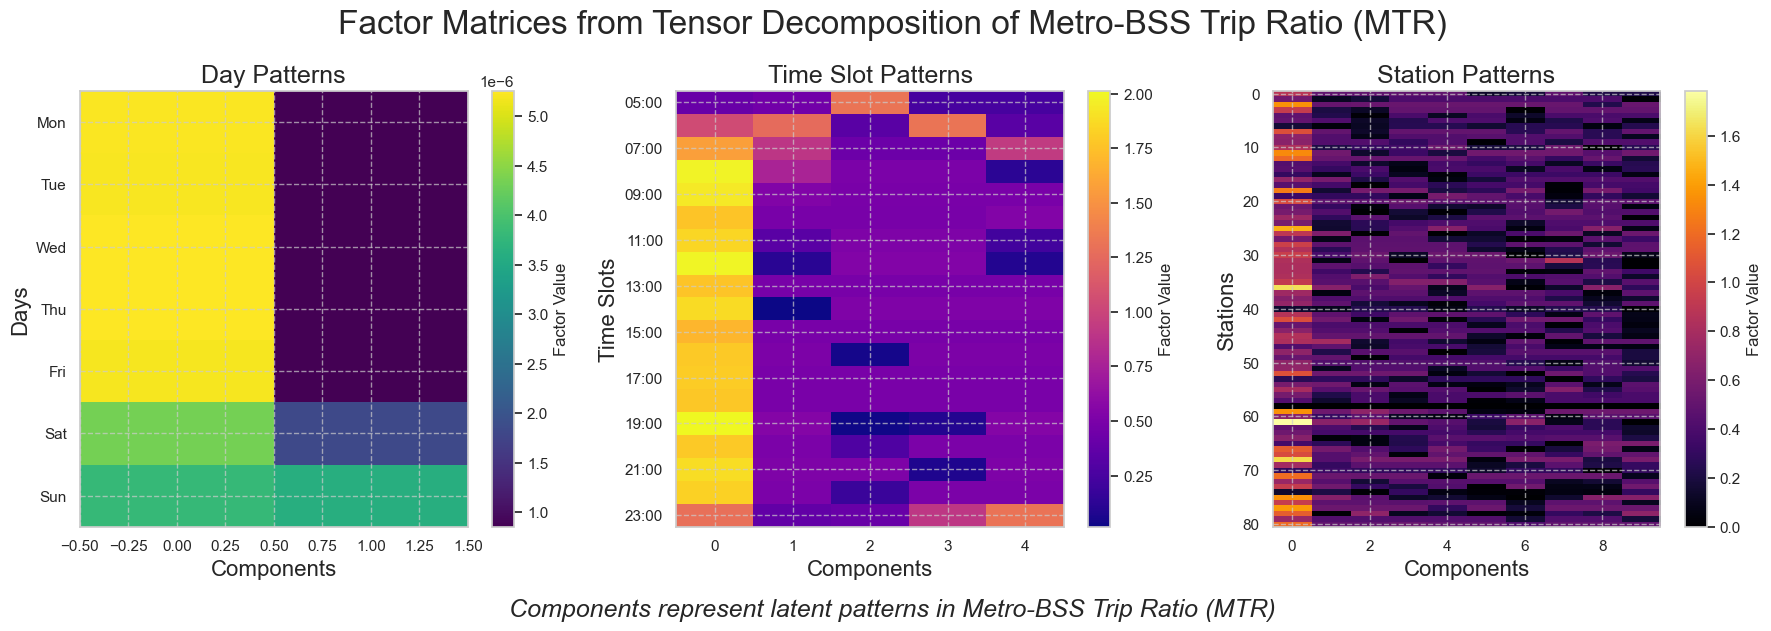

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

im1 = ax1.imshow(A2, aspect='auto', cmap='viridis')
ax1.set_title('Day Patterns', fontsize=18)
ax1.set_xlabel('Components', fontsize=16)
ax1.set_ylabel('Days', fontsize=16)
fig.colorbar(im1, ax=ax1, label='Factor Value')

im2 = ax2.imshow(B2, aspect='auto', cmap='plasma')
ax2.set_title('Time Slot Patterns', fontsize=18)
ax2.set_xlabel('Components', fontsize=16)
ax2.set_ylabel('Time Slots', fontsize=16)
fig.colorbar(im2, ax=ax2, label='Factor Value')

im3 = ax3.imshow(C2, aspect='auto', cmap='inferno')
ax3.set_title('Station Patterns', fontsize=18)
ax3.set_xlabel('Components', fontsize=16)
ax3.set_ylabel('Stations', fontsize=16)
fig.colorbar(im3, ax=ax3, label='Factor Value')

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax1.set_yticks(range(len(days)))
ax1.set_yticklabels(days)

time_slots = [f'{i+5:02d}:00' for i in range(20)]
ax2.set_yticks(range(0, len(time_slots), 2))
ax2.set_yticklabels(time_slots[::2])

fig.text(0.5, -0.02, 'Components represent latent patterns in Metro-BSS Trip Ratio (MTR)', 
         ha='center', va='center', fontsize=18, style='italic')

for ax in (ax1, ax2, ax3):
    ax.grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Factor Matrices from Tensor Decomposition of Metro-BSS Trip Ratio (MTR)', fontsize=24)
plt.tight_layout()
plt.show()

In [91]:
station_scores = np.sum(C2, axis=1)
top_stations = np.argsort(station_scores)[::-1][:5]
print(top_stations)

[68  2 77 80 61]


In [92]:
low_stations = np.argsort(station_scores)[::-1][-3:]
print(low_stations)

[40 74 58]


In [93]:
stations

['Aldgate East Underground Station',
 'Aldgate Underground Station',
 'Angel Underground Station',
 'Barbican Underground Station',
 'Barons Court Underground Station',
 'Battersea Power Station Underground Station',
 'Bermondsey Underground Station',
 'Bethnal Green Underground Station',
 'Blackfriars Underground Station',
 'Bond Street Underground Station',
 'Borough Underground Station',
 'Bow Road Underground Station',
 'Camden Town Underground Station',
 'Canada Water Underground Station',
 'Canary Wharf Underground Station',
 'Charing Cross Underground Station',
 'Clapham Common Underground Station',
 'Clapham North Underground Station',
 "Earl's Court Underground Station",
 'East Putney Underground Station',
 'Edgware Road (Bakerloo) Underground Station',
 'Edgware Road (Circle Line) Underground Station',
 'Embankment Underground Station',
 'Euston Square Underground Station',
 'Euston Underground Station',
 'Fulham Broadway Underground Station',
 'Gloucester Road Underground St

C:\Users\DELL\AppData\Local\Temp\ipykernel_28952\71479027.py:47: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_28952\71479027.py:47: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


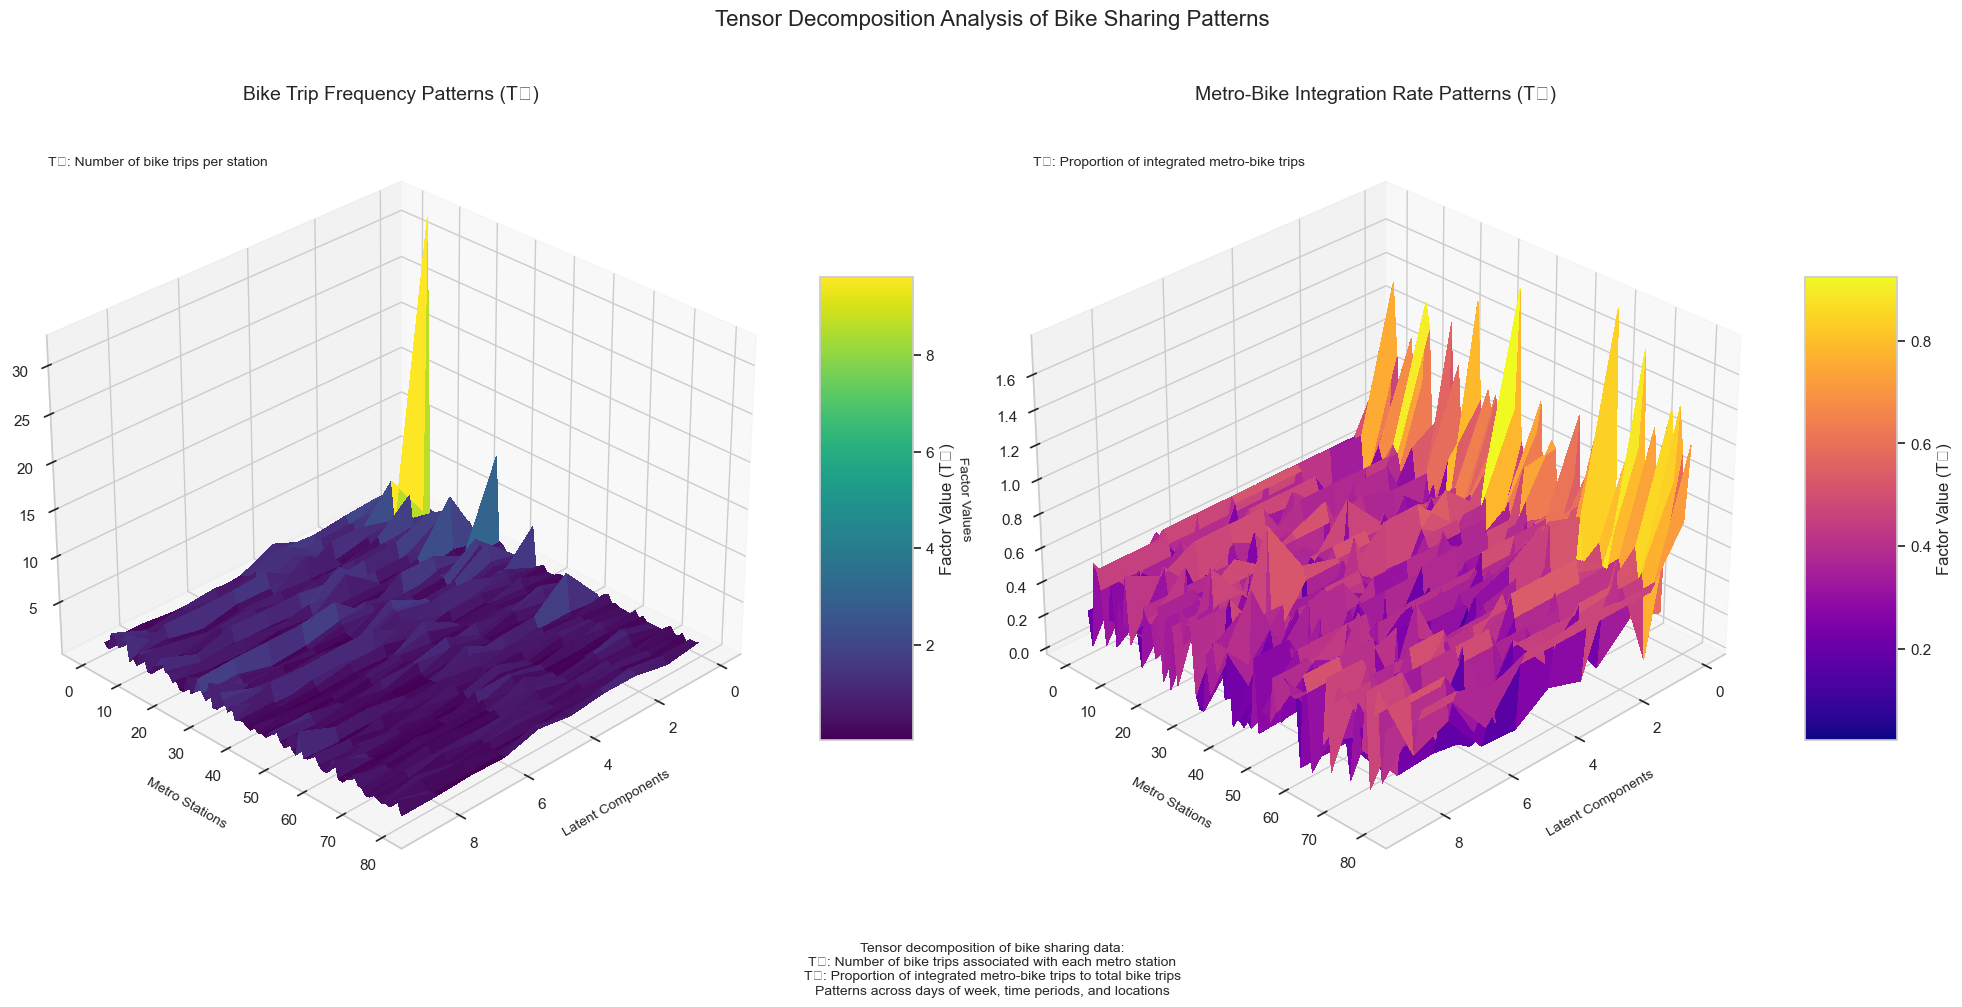

In [94]:
from matplotlib import cm

def plot_factor_matrix(ax, C, title, cmap):
    x, y = np.meshgrid(np.arange(C.shape[1]), np.arange(C.shape[0]))
    
    stride = 1 
    surf = ax.plot_surface(x[::stride, ::stride], 
                           y[::stride, ::stride], 
                           C[::stride, ::stride], 
                           rstride=1, cstride=1, 
                           cmap=cmap, 
                           linewidth=0, 
                           antialiased=False)
    
    ax.set_xlabel('Latent Components', fontsize=10, labelpad=10)
    ax.set_ylabel('Metro Stations', fontsize=10, labelpad=10)
    ax.set_zlabel('Factor Values', fontsize=10, labelpad=10)
    ax.set_title(title, fontsize=14, pad=20)
    
    ax.view_init(elev=30, azim=45)
    ax.grid(True)
    
    return surf

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121, projection='3d')
surf1 = plot_factor_matrix(ax1, C1, 'Bike Trip Frequency Patterns (T₁)', cm.viridis)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5, label='Factor Value (T₁)')
ax1.text2D(0.05, 0.95, "T₁: Number of bike trips per station", transform=ax1.transAxes, fontsize=10)

ax2 = fig.add_subplot(122, projection='3d')
surf2 = plot_factor_matrix(ax2, C2, 'Metro-Bike Integration Rate Patterns (T₂)', cm.plasma)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5, label='Factor Value (T₂)')
ax2.text2D(0.05, 0.95, "T₂: Proportion of integrated metro-bike trips", transform=ax2.transAxes, fontsize=10)

fig.suptitle('Tensor Decomposition Analysis of Bike Sharing Patterns', fontsize=16, y=0.98)

explanation = (
    "Tensor decomposition of bike sharing data:\n"
    "T₁: Number of bike trips associated with each metro station\n"
    "T₂: Proportion of integrated metro-bike trips to total bike trips\n"
    "Patterns across days of week, time periods, and locations"
)
fig.text(0.5, 0.02, explanation, ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# BSS demand prediction

#### Using historical BSS trip data and metro flow data (Monday, Tuesday-Thursday averages, and Friday) for peak hours over a one-month period, predict the BSS demand for metro riders at each station during peak hours for a day. 

In [95]:
lane = gpd.read_file("https://github.com/tianzhhai/dissertation/raw/main/bike_with_lane.geojson")

In [96]:
site = bikeinmetrobuffer[['name','MSOA11CD','POPDEN','geometry']]

In [97]:
site = site.merge(lane[['name','lane_density']], left_on='name', right_on='name')

In [98]:
point_list = []
original_data = []

for idx, row in site.iterrows():
    geom = row.geometry
    if geom.geom_type == 'MultiPoint':
        for point in geom.geoms:
            point_list.append(point)
            original_data.append(row.drop('geometry'))
    elif geom.geom_type == 'Point':
        point_list.append(geom)
        original_data.append(row.drop('geometry'))

points_df = pd.DataFrame(original_data)
points_df['geometry'] = point_list

site = gpd.GeoDataFrame(points_df, geometry='geometry', crs=site.crs)

In [99]:
def nearest_metro_info(bike_geom, metro):
    distances = metro.distance(bike_geom)
    nearest_index = distances.idxmin()
    return metro.loc[nearest_index, 'name'], distances.min()

site['nearest_metro_info'] = site['geometry'].apply(lambda x: nearest_metro_info(x, points_metro))

site['nearest_metro_id'] = site['nearest_metro_info'].apply(lambda x: x[0])
site['nearest_metro_distance'] = site['nearest_metro_info'].apply(lambda x: x[1])

site.drop(columns=['nearest_metro_info'], inplace=True)

#### Tuesday-Thursday averages

In [100]:
data1 = site.merge(metro_with_fll[['name', 'T_AM_Peak','T_PM_Peak']], left_on='nearest_metro_id', right_on='name')
data1 = data1.rename(columns={'T_AM_Peak': 'AM_Peak', 'T_PM_Peak': 'PM_Peak'})

amtotal = tripinbufferop[(tripinbufferop.period == 'AMpeak') & (tripinbufferop.Day_of_week > 0) & (tripinbufferop.Day_of_week < 4)].groupby('Start_station').size().reset_index(name='am_total')
pmtotal = tripinbufferop[(tripinbufferop.period == 'PMpeak') & (tripinbufferop.Day_of_week > 0) & (tripinbufferop.Day_of_week < 4)].groupby('Start_station').size().reset_index(name='pm_total')

ammuti = muti[(muti.period == 'AMpeak') & (muti.Day_of_week > 0) & (muti.Day_of_week < 4)].groupby('Start_station').size().reset_index(name='am_muti')
pmmuti = muti[(muti.period == 'PMpeak') & (muti.Day_of_week > 0) & (muti.Day_of_week < 4)].groupby('Start_station').size().reset_index(name='pm_muti')

merged_df = pd.merge(amtotal, pmtotal, on='Start_station', how='inner')
merged_df = pd.merge(merged_df, ammuti, on='Start_station', how='inner')
merged_df = pd.merge(merged_df, pmmuti, on='Start_station', how='inner')

merged_df.iloc[:, 1:] = (merged_df.iloc[:, 1:] / 12).astype(int)  # There are 12 Tuesday/Wedneday/Thursdays in the month

data1 = data1.merge(merged_df[['Start_station', 'am_total','pm_total','am_muti','pm_muti']], left_on='name_x', right_on='Start_station')

#### Monday

In [101]:
data2 = site.merge(metro_with_fll[['name', 'M_AM_Peak','M_PM_Peak']], left_on='nearest_metro_id', right_on='name')
data2 = data2.rename(columns={'M_AM_Peak': 'AM_Peak', 'M_PM_Peak': 'PM_Peak'})

amtotal = tripinbufferop[(tripinbufferop.period == 'AMpeak') & (tripinbufferop.Day_of_week ==0)].groupby('Start_station').size().reset_index(name='am_total')
pmtotal = tripinbufferop[(tripinbufferop.period == 'PMpeak') & (tripinbufferop.Day_of_week ==0) ].groupby('Start_station').size().reset_index(name='pm_total')

ammuti = muti[(muti.period == 'AMpeak') & (muti.Day_of_week ==0)].groupby('Start_station').size().reset_index(name='am_muti')
pmmuti = muti[(muti.period == 'PMpeak') & (muti.Day_of_week ==0)].groupby('Start_station').size().reset_index(name='pm_muti')

merged_df = pd.merge(amtotal, pmtotal, on='Start_station', how='inner')
merged_df = pd.merge(merged_df, ammuti, on='Start_station', how='inner')
merged_df = pd.merge(merged_df, pmmuti, on='Start_station', how='inner')

merged_df.iloc[:, 1:] = (merged_df.iloc[:, 1:] / 5).astype(int)  # There are 5 Mondays in the month

data2 = data2.merge(merged_df[['Start_station', 'am_total','pm_total','am_muti','pm_muti']], left_on='name_x', right_on='Start_station')

#### Friday

In [102]:
data3 = site.merge(metro_with_fll[['name', 'F_AM_Peak','F_PM_Peak']], left_on='nearest_metro_id', right_on='name')
data3 = data3.rename(columns={'F_AM_Peak': 'AM_Peak', 'F_PM_Peak': 'PM_Peak'})

amtotal = tripinbufferop[(tripinbufferop.period == 'AMpeak') & (tripinbufferop.Day_of_week ==4)].groupby('Start_station').size().reset_index(name='am_total')
pmtotal = tripinbufferop[(tripinbufferop.period == 'PMpeak') & (tripinbufferop.Day_of_week ==4)].groupby('Start_station').size().reset_index(name='pm_total')

ammuti = muti[(muti.period == 'AMpeak') & (muti.Day_of_week == 4)].groupby('Start_station').size().reset_index(name='am_muti')
pmmuti = muti[(muti.period == 'PMpeak') & (muti.Day_of_week == 4)].groupby('Start_station').size().reset_index(name='pm_muti')

merged_df = pd.merge(amtotal, pmtotal, on='Start_station', how='inner')
merged_df = pd.merge(merged_df, ammuti, on='Start_station', how='inner')
merged_df = pd.merge(merged_df, pmmuti, on='Start_station', how='inner')

merged_df.iloc[:, 1:] = (merged_df.iloc[:, 1:] / 4).astype(int)   #There are 4 Fridays in the month

data3 = data3.merge(merged_df[['Start_station', 'am_total','pm_total','am_muti','pm_muti']], left_on='name_x', right_on='Start_station')

In [103]:
data = pd.concat([data1, data2, data3], ignore_index=True)

In [104]:
data = data.dropna()

In [105]:
data['peak_flow'] = data['AM_Peak'] + data['PM_Peak']
data['multi_trips'] = data['am_muti'] + data['pm_muti']
data['total_trips'] = data['am_total'] + data['pm_total']
data['mtr'] = data['multi_trips']/data['total_trips']

In [106]:
X = data[['POPDEN', 'peak_flow','lane_density']]
y = data['multi_trips']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.
print(X_train.index.identical(y_train.index))
print(X_test.index.identical(y_test.index))

(234, 3)
(234,)
(59, 3)
(59,)
True
True


In [108]:
# values of max_depth and min_samples_split
hyperparameters = {'n_estimators': [100, 200, 300], 'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 42
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)

The best parameter value is: 
{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}


In [109]:
rf_final = RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'], max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=10, random_state=42)

In [110]:
y_pred = rf_final.predict(X_test)

In [111]:
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

Mean Squared Error: 16.92342068992704
Root Mean Squared Error: 4.113808538316658
Mean Absolute Error: 3.314322914236883
R² Score: 0.8052856822003913


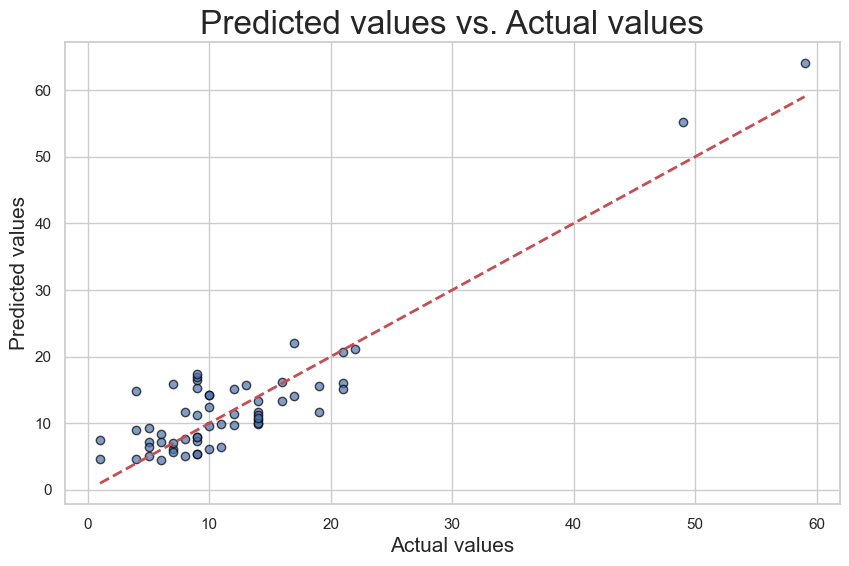

In [112]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0), alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual values', fontsize=15)
plt.ylabel('Predicted values', fontsize=15)
plt.title('Predicted values vs. Actual values', fontsize=24)
plt.show()

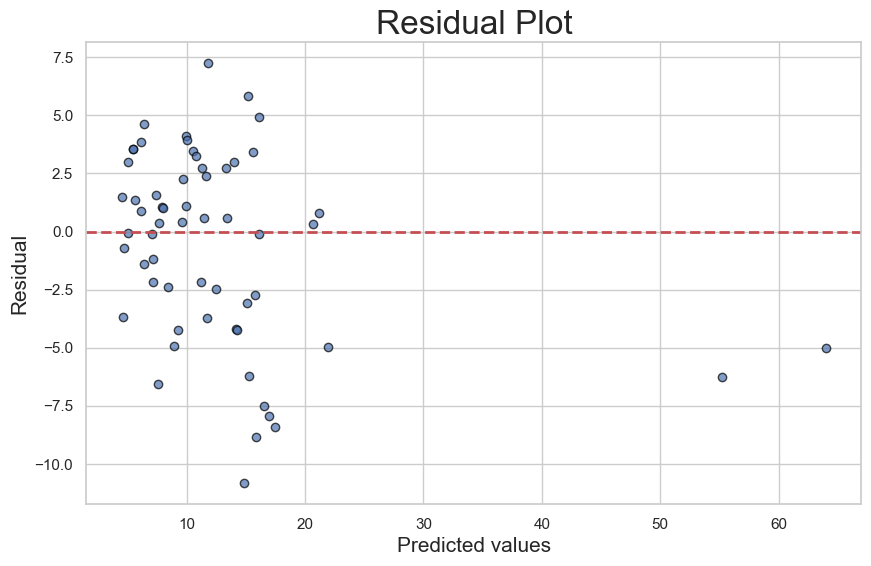

In [113]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, edgecolors=(0, 0, 0), alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted values', fontsize=15)
plt.ylabel('Residual', fontsize=15)
plt.title('Residual Plot', fontsize=24)
plt.show()

In [115]:
scopelane = gpd.read_file("https://github.com/tianzhhai/dissertation/raw/main/scopejoinlane.geojson")

metrolane = metro_with_fll.merge(scopelane[['MSOA11CD','lane_density']], left_on='MSOA11CD', right_on='MSOA11CD')
metrolane['lane_density'] = metrolane['lane_density'].fillna(0)
metrolane['peak_flow'] = metrolane['T_AM_Peak'] + metrolane['T_PM_Peak']

X_new = metrolane[['POPDEN', 'peak_flow','lane_density']]
predictions = rf_final.predict(X_new)
metrolane['Predictions'] = predictions

D:\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
D:\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


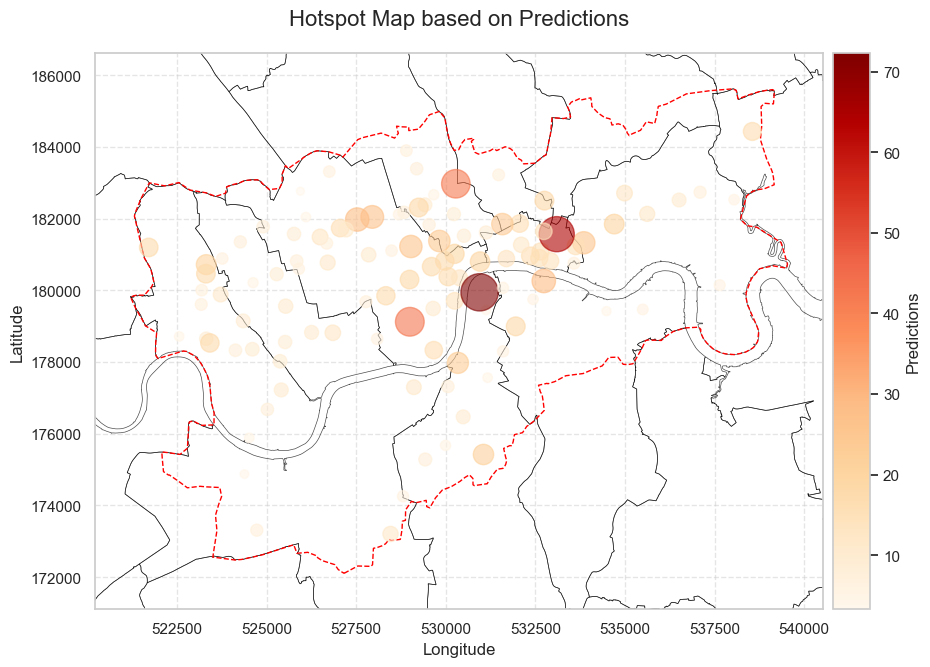

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

x_min, y_min, x_max, y_max = scope.total_bounds

london.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, alpha=0.7)
scope.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, linestyle='--')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  

plot = metrolane.plot(
    ax=ax,
    column='Predictions',  
    cmap='OrRd',           
    markersize=metrolane['Predictions'] * 10, 
    alpha=0.6,             
    legend=False          
)

ax.set_title('Hotspot Map based on Predictions', fontsize=16, pad=20)
ax.set_xlabel('Longitude', fontsize=12,)
ax.set_ylabel('Latitude', fontsize=12,)

ax.set_xlim(x_min-1000, x_max+1000)
ax.set_ylim(y_min-1000, y_max+1000)

sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=metrolane['Predictions'].min(), vmax=metrolane['Predictions'].max()))
sm._A = []  
cbar = plt.colorbar(sm, cax=cax)  

cbar.set_label('Predictions', fontsize=12)

ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

# Cluster metro stations

In [117]:
metroforcluster = points_metro.merge(metrolane[['name','Predictions']], left_on='name', right_on='name')

In [118]:
peakmuti = muti[muti['period'] != 'offpeak']
peakmuti = peakmuti['name_2'].value_counts().reset_index()
peakmuti.columns = ['metro', 'peakmuti']
peakmuti['peakmuti'] = peakmuti['peakmuti'] / 21    #There are 21 workdays in the month.

peaktotal = tripinbuffer[tripinbuffer['period'] != 'offpeak']
peaktotal = peaktotal['name_2'].value_counts().reset_index()
peaktotal.columns = ['metro', 'peaktotal']
peaktotal['peaktotal'] = peaktotal['peaktotal'] / 21

peaktotal = peaktotal.merge(peakmuti[['metro','peakmuti']], left_on='metro', right_on='metro')
peaktotal['mtr'] = peaktotal['peakmuti'] / peaktotal['peaktotal']

In [119]:
metroforcluster1 = metroforcluster.merge(peaktotal[['metro','mtr']], left_on='name', right_on='metro', how='left')
metroforcluster1['mtr'] = metroforcluster1['mtr'].fillna(0)

In [120]:
data_cluster = metroforcluster1[['bike_connectivity_index', 'mtr', 'Predictions']]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cluster)

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

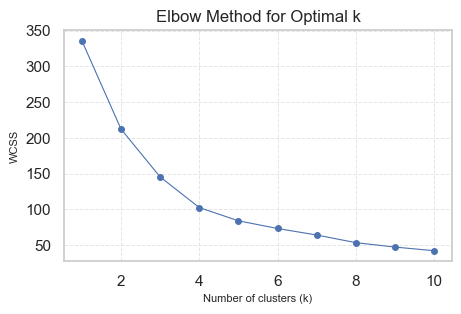

In [121]:
wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(5, 3))

plt.plot(range(1, 11), wcss, marker='o',markersize=4,linewidth=0.8)
plt.title('Elbow Method for Optimal k', fontsize=12)
plt.xlabel('Number of clusters (k)', fontsize=8)
plt.ylabel('WCSS', fontsize=8)

ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)

plt.show()

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

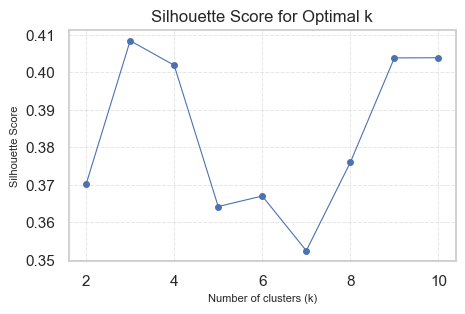

In [122]:
sil_scores = []
for i in range(2, 11): 
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    clusters = kmeans.fit_predict(data_scaled)
    sil_score = silhouette_score(data_scaled, clusters)
    sil_scores.append(sil_score)

fig, ax = plt.subplots(figsize=(5, 3))

plt.plot(range(2, 11), sil_scores, marker='o',markersize=4,linewidth=0.8)
plt.title('Silhouette Score for Optimal k', fontsize=12)
plt.xlabel('Number of clusters (k)', fontsize=8)
plt.ylabel('Silhouette Score', fontsize=8)

ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)

plt.show()

In [123]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
metroforcluster1['cluster'] = kmeans.fit_predict(data_scaled)

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


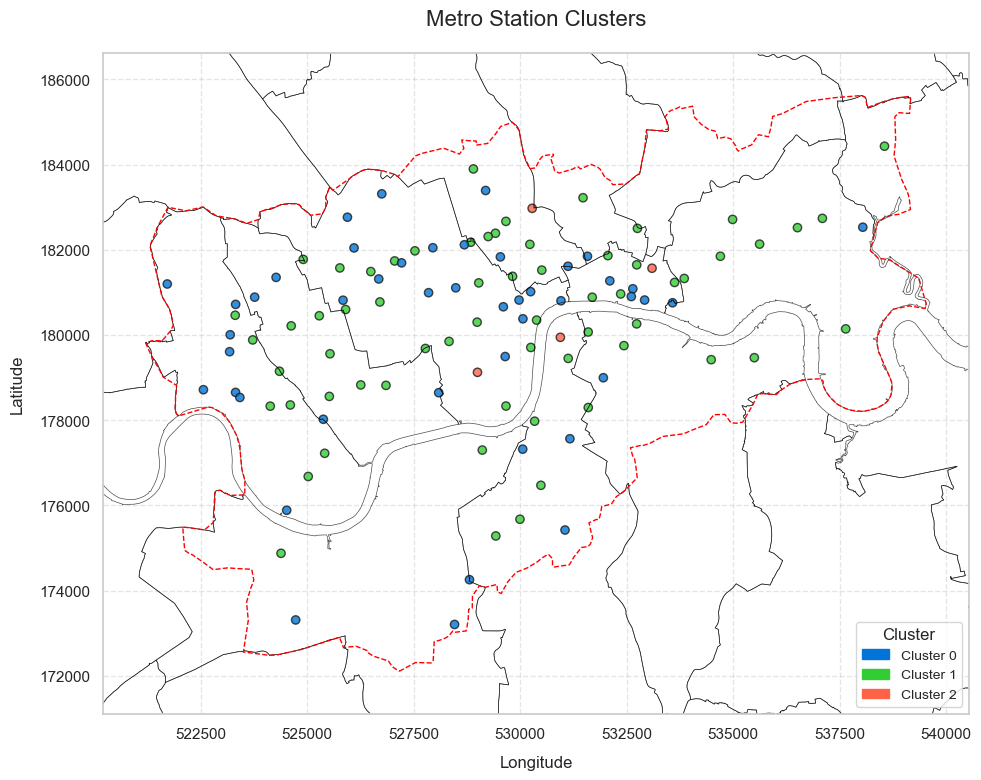

In [124]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#0074D9', '#32CD32', '#FF6347']
cmap = ListedColormap(colors)

x_min, y_min, x_max, y_max = scope.total_bounds
metroforcluster1.plot(column='cluster', cmap=cmap, legend=False, ax=ax, edgecolor='k', alpha=0.8)
london.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, alpha=0.7)
scope.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, linestyle='--')

handles = []
for i, color in enumerate(colors):
    handles.append(patches.Patch(color=color, label=f'Cluster {i}'))
    
ax.legend(handles=handles, title='Cluster', loc='lower right', fontsize='small')
plt.title('Metro Station Clusters', fontsize=16, pad=20)
plt.xlabel('Longitude', fontsize=12, labelpad=10)
plt.ylabel('Latitude', fontsize=12, labelpad=10)
ax.set_xlim(x_min-1000, x_max+1000)
ax.set_ylim(y_min-1000, y_max+1000)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [125]:
cluster_descriptions = metroforcluster1.groupby('cluster').agg({
    'bike_connectivity_index': ['mean', 'std', 'min', 'max'],
    'mtr': ['mean', 'std', 'min', 'max'],
    'Predictions': ['mean', 'std', 'min', 'max']
})


print(cluster_descriptions)

        bike_connectivity_index                                       mtr  \
                           mean        std       min        max      mean   
cluster                                                                     
0                      3.606536   7.113700  0.000000  28.000000  0.096606   
1                     26.552754  17.543811  2.117647  83.000000  0.562817   
2                     25.220588  16.168759  1.882353  38.705882  0.699443   

                                      Predictions                        \
              std       min       max        mean        std        min   
cluster                                                                   
0        0.163085  0.000000  0.478022   11.291445   5.930799   3.336001   
1        0.153144  0.183463  0.859935   12.045346   6.073686   3.898136   
2        0.147144  0.571722  0.870598   55.307406  15.218220  42.143997   

                    
               max  
cluster             
0        26.814195  
1 

In [126]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
metroforcluster1['cluster'] = kmeans.fit_predict(data_scaled)

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


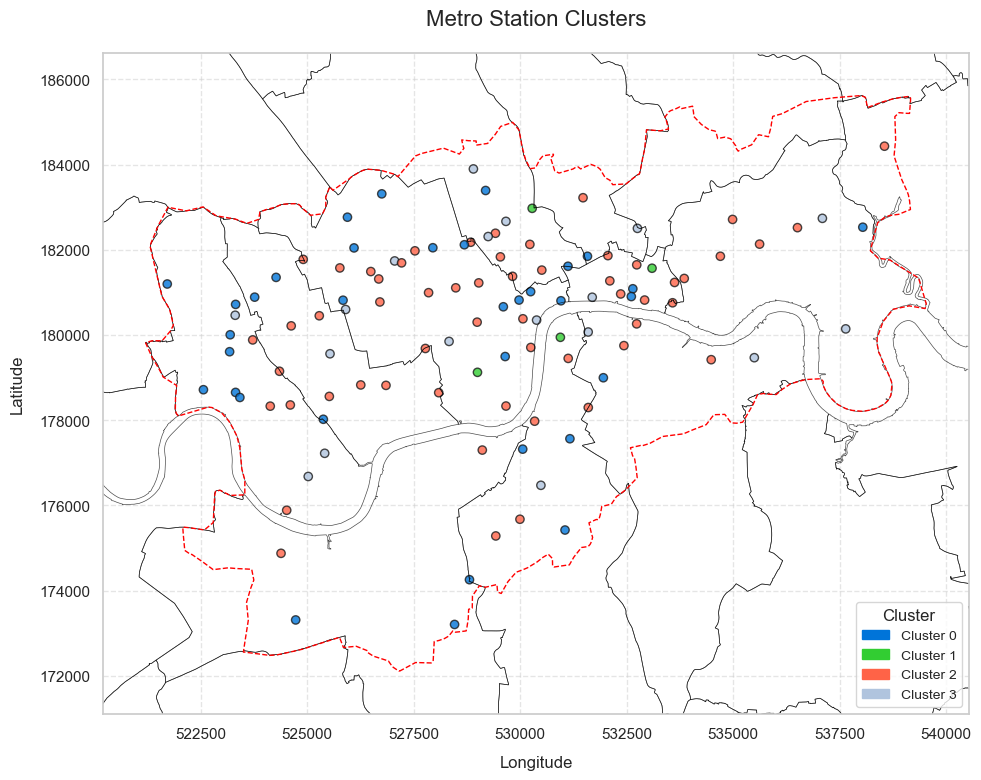

In [127]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#0074D9', '#32CD32', '#FF6347', '#B0C4DE']
cmap = ListedColormap(colors)

x_min, y_min, x_max, y_max = scope.total_bounds
metroforcluster1.plot(column='cluster', cmap=cmap, legend=False, ax=ax, edgecolor='k', alpha=0.8)
london.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, alpha=0.7)
scope.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, linestyle='--')

handles = []
for i, color in enumerate(colors):
    handles.append(patches.Patch(color=color, label=f'Cluster {i}'))
    
ax.legend(handles=handles, title='Cluster', loc='lower right', fontsize='small')
plt.title('Metro Station Clusters', fontsize=16, pad=20)
plt.xlabel('Longitude', fontsize=12, labelpad=10)
plt.ylabel('Latitude', fontsize=12, labelpad=10)
ax.set_xlim(x_min-1000, x_max+1000)
ax.set_ylim(y_min-1000, y_max+1000)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [128]:
cluster_descriptions = metroforcluster1.groupby('cluster').agg({
    'bike_connectivity_index': ['mean', 'std', 'min', 'max'],
    'mtr': ['mean', 'std', 'min', 'max'],
    'Predictions': ['mean', 'std', 'min', 'max']
})


print(cluster_descriptions)

        bike_connectivity_index                                        mtr  \
                           mean        std        min        max      mean   
cluster                                                                      
0                      2.756055   7.576005   0.000000  28.000000  0.009664   
1                     25.220588  16.168759   1.882353  38.705882  0.699443   
2                     15.517857   9.073080   1.882353  30.000000  0.531046   
3                     48.467320  15.076756  34.705882  83.000000  0.540977   

                                      Predictions                        \
              std       min       max        mean        std        min   
cluster                                                                   
0        0.047120  0.000000  0.270270   11.836904   6.433214   3.336001   
1        0.147144  0.571722  0.870598   55.307406  15.218220  42.143997   
2        0.166039  0.183463  0.859935   11.910158   6.158243   3.898136   
3  

In [129]:
df_cluster0 = metroforcluster1[metroforcluster1['cluster']==0][['name','bike_connectivity_index','mtr','Predictions']]
# df_cluster0.to_csv('cluster0_data.csv', index=False)

df_cluster1 = metroforcluster1[metroforcluster1['cluster']==1][['name','bike_connectivity_index','mtr','Predictions']]
# df_cluster1.to_csv('cluster1_data.csv', index=False)

df_cluster2 = metroforcluster1[metroforcluster1['cluster']==2][['name','bike_connectivity_index','mtr','Predictions']]
# df_cluster2.to_csv('cluster2_data.csv', index=False)

df_cluster3 = metroforcluster1[metroforcluster1['cluster']==3][['name','bike_connectivity_index','mtr','Predictions']]
# df_cluster3.to_csv('cluster3_data.csv', index=False)

In [130]:
# bikeinmetrobuffer[bikeinmetrobuffer['name_2']=='Clapham South Underground Station']

In [131]:
# bikeinmetrobuffer[bikeinmetrobuffer['name_2']=='Ravenscourt Park Underground Station']

In [132]:
# bikeinmetrobuffer[bikeinmetrobuffer['name_2']=='Temple Underground Station']

In [133]:
# bikeinmetrobuffer[bikeinmetrobuffer['name_2']=='Warwick Avenue Underground Station']